# Initialization and Setup

In [ ]:
!pip install -q tensorflow-model-optimization

import tempfile
import os
import time
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
from random import shuffle

import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd

from tensorflow import keras
import tensorflow_model_optimization as tfmot



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Full Dataset can be found at https://www.kaggle.com/datasets/debashishsau/aslamerican-sign-language-aplhabet-dataset?select=ASL_Alphabet_Dataset.

No modifications needed to load in full dataset

In [ ]:
# Directory for loading Dataset
'''
The dataset must be saved in this format
Dataset/asl_alphabet_train/{directories holding training images}/{train_images.png}
Dataset/asl_alphabet_test/{labeled_test_image.png}
'''
import os
# os.chdir('/content/drive/My Drive/ENDG511/Dataset/') # Johnson
# os.chdir('/content/drive/My Drive/Colab Notebooks/ENDG511/Dataset/') # Tommy
os.chdir('/content/drive/My Drive/Colab Notebooks/Dataset/') # Adam


In [ ]:
'''
this code block loads in the test dataset
'''
import os
import glob
import cv2
from PIL import Image
import numpy as np

# Define the target size for resizing images
target_size = (200, 200)  # Adjust as needed

# Get the file paths for images in the directory
test_images_paths = glob.glob(os.getcwd() + '/asl_alphabet_test/*.jpg')

# Initialize lists to store images and labels
test_images = []
test_labels = []

# Load and preprocess images
for image_path in test_images_paths:
    # Extract label from the filename
    filename = os.path.basename(image_path)
    label = filename.split('_')[0]

    # Load image and resize
    image = cv2.imread(image_path)
    image = cv2.resize(image,target_size)
    # Normalize pixel values and convert to numpy array
    image = np.array(image) / 255.0
    test_images.append(image)
    test_labels.append(label)


# Convert lists to numpy arrays
test_images = np.array(test_images)
test_labels = np.array(test_labels)

# Print shapes of images and labels
print("Shape of test_images:", test_images.shape)
print("Shape of test_labels:", test_labels.shape)

# Create a mapping from integer labels to string labels
unique_labels = np.unique(test_labels)
label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
index_to_label = {idx: label for label, idx in label_to_index.items()}

# Print the mapping
for idx, label in index_to_label.items():
    print(f"Integer label {idx} corresponds to string label '{label}'")

test_labels_indexed = np.array([label_to_index[label] for label in test_labels])
# print(test_labels_indexed)
# print(test_labels)

Shape of test_images: (284, 200, 200, 3)
Shape of test_labels: (284,)
Integer label 0 corresponds to string label 'C'
Integer label 1 corresponds to string label 'K'
Integer label 2 corresponds to string label 'L'
Integer label 3 corresponds to string label 'W'
Integer label 4 corresponds to string label 'Y'


In [ ]:
'''
this code block loads in the training dataset
'''
import os
import glob
import cv2
import numpy as np
from multiprocessing import Pool
from tqdm.notebook import tqdm  # For progress bar in Jupyter Notebook

# Define the target size for resizing images
target_size = (200, 200)  # Adjust as needed

# Function to load and preprocess an image given its file path
def load_and_preprocess_image(image_path):
    # Extract label from image path
    label = os.path.basename(os.path.dirname(image_path))
    # Load and resize image
    image = cv2.imread(image_path)
    image = cv2.resize(image, target_size)

    # Normalize pixel values and convert to numpy array
    image = np.array(image) / 255.0


    return image, label

# Get the file paths for images in the directory
train_images_paths = glob.glob(os.getcwd() + '/asl_alphabet_train/*/*.jpg')
# for image_path in train_images_paths:
#     label = os.path.basename(os.path.dirname(image_path))
#     if label not in ['C', 'K', 'L', 'W', 'Y']:
#         train_images_paths.remove(image_path)

# Use all available CPU cores
num_processes = os.cpu_count()

# Create a multiprocessing pool
with Pool(num_processes) as pool:
    # Load and preprocess images in parallel
    results = list(tqdm(pool.imap(load_and_preprocess_image, train_images_paths[::]), total=len(train_images_paths)//1))

# Extract images and labels from results
train_images, train_labels = zip(*results)

# Convert lists to numpy arrays
train_images = np.array(train_images)
train_labels = np.array(train_labels)

# Print shapes of images and labels
print("Shape of train_images:", train_images.shape)
print("Shape of train_labels:", train_labels.shape)

# Create a mapping from string labels to integer labels
unique_labels = np.unique(train_labels)
label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
index_to_label = {idx: label for label, idx in label_to_index.items()}

# Print the mapping
for idx, label in index_to_label.items():
    print(f"Integer label {idx} corresponds to string label '{label}'")

# Convert string labels to integer labels
train_labels_indexed = np.array([label_to_index[label] for label in train_labels])


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/1150 [00:00<?, ?it/s]

Shape of train_images: (1150, 200, 200, 3)
Shape of train_labels: (1150,)
Integer label 0 corresponds to string label 'C'
Integer label 1 corresponds to string label 'K'
Integer label 2 corresponds to string label 'L'
Integer label 3 corresponds to string label 'W'
Integer label 4 corresponds to string label 'Y'


In [ ]:
# shuffle data
ind_list = [i for i in range(len(train_images))]
shuffle(ind_list)
train_images_shuffled  = train_images[ind_list, :,:,:]
train_labels_indexed_shuffled = train_labels_indexed[ind_list,]


In [ ]:
train_labels_indexed_shuffled

array([3, 2, 3, ..., 1, 3, 0])

In [ ]:
'''
Base Model
'''
import tensorflow as tf

# Create a new Sequential model
lenet_5_model = tf.keras.models.Sequential()

lenet_5_model.add(layers.Conv2D(filters=32, kernel_size=(3,3), strides=1, padding='same', activation='relu', input_shape=(200, 200, 3)))
# lenet_5_model.add(layers.Conv2D(filters=32, kernel_size=3, strides=1, activation='relu'
lenet_5_model.add(layers.MaxPooling2D(pool_size=(2,2)))
# lenet_5_model.add(layers.Dropout(0.1))

# lenet_5_model.add(layers.Conv2D(filters=64, kernel_size=3, strides=1, activation='relu'))
lenet_5_model.add(layers.Conv2D(filters=64, kernel_size=3, strides=1, activation='relu'))
lenet_5_model.add(layers.MaxPooling2D(pool_size=(2,2)))
# lenet_5_model.add(layers.Dropout(0.1))

# lenet_5_model.add(layers.Conv2D(filters=64, kernel_size=3, strides=1, activation='relu'))
lenet_5_model.add(layers.Conv2D(filters=64, kernel_size=3, strides=1, activation='relu'))
lenet_5_model.add(layers.MaxPooling2D(pool_size=(2,2)))
# lenet_5_model.add(layers.Dropout(0.1))

lenet_5_model.add(layers.Flatten())
lenet_5_model.add(layers.Dense(48, activation='relu'))
# lenet_5_model.add(layers.Dense(16, activation='relu'))
lenet_5_model.add(layers.Dense(5, activation='softmax'))

# Print model summary to verify input shape
lenet_5_model.summary()


lenet_5_model.save('untrained_cnn_model.h5')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 200, 200, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 100, 100, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 98, 98, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 49, 49, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 47, 47, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 23, 23, 64)        0

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0003)
lenet_5_model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = lenet_5_model.fit(train_images_shuffled, train_labels_indexed_shuffled, epochs=8,
                    validation_data=(test_images, test_labels_indexed))

lenet_5_model.summary()

lenet_5_model.save('trained_cnn_model_5let.h5')

Epoch 1/8


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


36/36 [==============================] - 13s 104ms/step - loss: 1.5610 - accuracy: 0.3096 - val_loss: 1.4325 - val_accuracy: 0.3803
Epoch 2/8
36/36 [==============================] - 1s 42ms/step - loss: 1.2899 - accuracy: 0.4678 - val_loss: 1.1724 - val_accuracy: 0.5246
Epoch 3/8
36/36 [==============================] - 1s 41ms/step - loss: 1.0299 - accuracy: 0.5939 - val_loss: 0.9769 - val_accuracy: 0.6690
Epoch 4/8
36/36 [==============================] - 2s 49ms/step - loss: 0.7438 - accuracy: 0.7296 - val_loss: 0.8283 - val_accuracy: 0.6866
Epoch 5/8
36/36 [==============================] - 2s 51ms/step - loss: 0.5553 - accuracy: 0.8043 - val_loss: 0.6945 - val_accuracy: 0.7958
Epoch 6/8
36/36 [==============================] - 2s 42ms/step - loss: 0.4043 - accuracy: 0.8791 - val_loss: 0.5681 - val_accuracy: 0.8627
Epoch 7/8
36/36 [==============================] - 1s 42ms/step - loss: 0.2635 - accuracy: 0.9148 - val_loss: 0.5803 - val_accuracy: 0.8592
Epoch 8/8
36/36 [===========

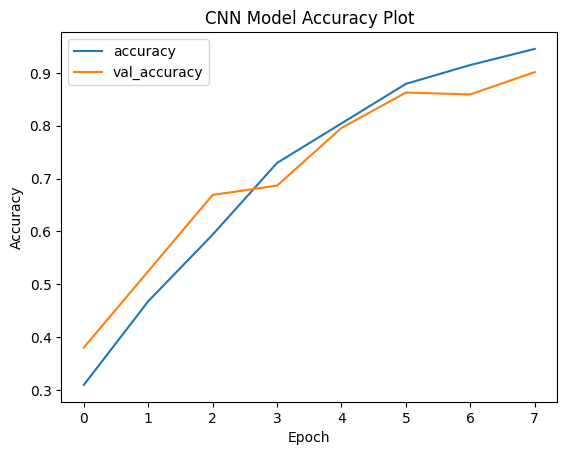

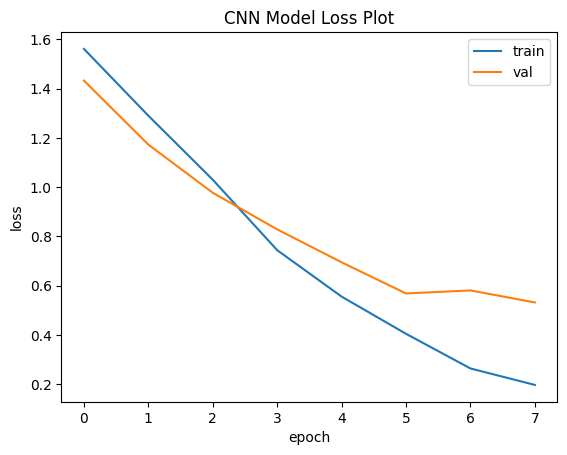

In [ ]:
# plotting accuracy and loss
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.title('CNN Model Accuracy Plot')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('CNN Model Loss Plot')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='best')
plt.show()

In [ ]:
# Evaluate prediction accuracy
lenet_5_model = tf.keras.models.load_model('trained_cnn_model_5let.h5')
test_loss, test_acc = lenet_5_model.evaluate(test_images,  test_labels_indexed, verbose=0)

# Evaluate Model Size
def get_gzipped_model_size(file):
  # Returns size of gzipped model, in bytes.
  import os
  import zipfile

  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  return os.path.getsize(zipped_file)


# Evaluate Inference Time
startTime = time.time()
prediction = lenet_5_model.predict(test_images)
executionTime = (time.time() - startTime)/len(test_images)


base_model_size = get_gzipped_model_size('untrained_cnn_model.h5')
## Print without stripping
pruned_model_size_50 = get_gzipped_model_size('stripped_pruned_50_lenet_5_model.h5')

# Print
print('\nBase Model Accuracy:', test_acc*100, '%')
print("Base Model Size: %.2f bytes" % (base_model_size))
print("Base Inference Time is", executionTime, "s")

base_model_vector = [test_acc*100, base_model_size, executionTime]

9/9 [==============================] - 0s 15ms/step

Base Model Accuracy: 90.14084339141846 %
Base Model Size: 6168725.00 bytes
Base Inference Time is 0.0019901957310421367 s


# 50% One-shot Pruning

In [ ]:
lenet_5_model = tf.keras.models.load_model('trained_cnn_model_5let.h5')

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# Define model for pruning. The 0.5 is the target sparsity (50%)
pruning_params = {
    'pruning_schedule': tfmot.sparsity.keras.ConstantSparsity(0.5, begin_step=0, frequency=10)
}

pruned_lenet_5_model = prune_low_magnitude(lenet_5_model, **pruning_params)

# `prune_low_magnitude` requires a recompile.
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
pruned_lenet_5_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

pruned_lenet_5_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_conv2d  (None, 200, 200, 32)      1762      
  (PruneLowMagnitude)                                            
                                                                 
 prune_low_magnitude_max_po  (None, 100, 100, 32)      1         
 oling2d (PruneLowMagnitude                                      
 )                                                               
                                                                 
 prune_low_magnitude_conv2d  (None, 98, 98, 64)        36930     
 _1 (PruneLowMagnitude)                                          
                                                                 
 prune_low_magnitude_max_po  (None, 49, 49, 64)        1         
 oling2d_1 (PruneLowMagnitu                                      
 de)                                                    

In [ ]:
# callback + re-train
callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
]

pruned_lenet_5_model.fit(train_images_shuffled, train_labels_indexed_shuffled, epochs=4,
                    validation_data=(test_images, test_labels_indexed),
                  callbacks=callbacks)

Epoch 1/4


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


36/36 [==============================] - 6s 72ms/step - loss: 1.0264 - accuracy: 0.7035 - val_loss: 0.9872 - val_accuracy: 0.6514
Epoch 2/4
36/36 [==============================] - 2s 55ms/step - loss: 0.4601 - accuracy: 0.8583 - val_loss: 0.5846 - val_accuracy: 0.8415
Epoch 3/4
36/36 [==============================] - 2s 48ms/step - loss: 0.2493 - accuracy: 0.9287 - val_loss: 0.6085 - val_accuracy: 0.8345
Epoch 4/4
36/36 [==============================] - 2s 48ms/step - loss: 0.1578 - accuracy: 0.9591 - val_loss: 0.5634 - val_accuracy: 0.9155


In [ ]:
# strip and save model
stripped_pruned_lenet_5_model = tfmot.sparsity.keras.strip_pruning(pruned_lenet_5_model)
stripped_pruned_lenet_5_model.save('stripped_pruned_50_lenet_5_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
def print_model_weights_sparsity(model):

    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.Wrapper):
            weights = layer.trainable_weights
        else:
            weights = layer.weights
        for weight in weights:
            if "kernel" not in weight.name or "centroid" in weight.name:
                continue
            weight_size = weight.numpy().size
            zero_num = np.count_nonzero(weight == 0)
            print(
                f"{weight.name}: {zero_num/weight_size:.2%} sparsity ",
                f"({zero_num}/{weight_size})",
            )
print_model_weights_sparsity(stripped_pruned_lenet_5_model)


conv2d/kernel:0: 50.00% sparsity  (432/864)
conv2d_1/kernel:0: 50.00% sparsity  (9216/18432)
conv2d_2/kernel:0: 50.00% sparsity  (18432/36864)
dense/kernel:0: 50.00% sparsity  (812544/1625088)
dense_1/kernel:0: 50.00% sparsity  (120/240)


In [ ]:
# Evaluate prediction accuracy
lenet_5_model = tf.keras.models.load_model('trained_cnn_model_5let.h5')
test_loss, test_acc = lenet_5_model.evaluate(test_images,  test_labels_indexed, verbose=0)
test_loss_pruned_50, test_acc_pruned_50 = pruned_lenet_5_model.evaluate(test_images,  test_labels_indexed, verbose=0)


# Evaluate Model Size
def get_gzipped_model_size(file):
  # Returns size of gzipped model, in bytes.
  import os
  import zipfile

  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  return os.path.getsize(zipped_file)


# Evaluate Inference Time
startTime = time.time()
prediction = lenet_5_model.predict(test_images)
executionTime = (time.time() - startTime)/len(test_images)

startTime = time.time()
prediction = pruned_lenet_5_model.predict(test_images)
executionTimePruned50 = (time.time() - startTime)/len(test_images)

base_model_size = get_gzipped_model_size('untrained_cnn_model.h5')
## Print without stripping
pruned_model_size_50 = get_gzipped_model_size('stripped_pruned_50_lenet_5_model.h5')

# Print
print('\nBase Model Accuracy:', test_acc*100, '%')
print("Base Model Size: %.2f bytes" % (base_model_size))
print("Base Inference Time is", executionTime, "s")

base_model_vector = [test_acc*100, base_model_size, executionTime]
prune_model50_vector = [test_acc_pruned_50*100, pruned_model_size_50, executionTimePruned50]

print('\nPruned Model Accuracy:', test_acc_pruned_50*100, '%')
print("Pruned Model Size: %.2f bytes" % (pruned_model_size_50))
print("Pruned Inference Time is", executionTimePruned50, "s")

9/9 [==============================] - 0s 15ms/step

Base Model Accuracy: 90.14084339141846 %
Base Model Size: 6168725.00 bytes
Base Inference Time is 0.0022955293386754854 s

Pruned Model Accuracy: 91.54929518699646 %
Pruned Model Size: 3810638.00 bytes
Pruned Inference Time is 0.0024660019807412593 s


# <br> 10% One-shot Pruning

In [ ]:
lenet_5_model = tf.keras.models.load_model('trained_cnn_model_5let.h5')

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# Define model for pruning. The 0.1 is the target sparsity (10%)
pruning_params = {
    'pruning_schedule': tfmot.sparsity.keras.ConstantSparsity(0.1, begin_step=0, frequency=10)
}

pruned_lenet_5_model = prune_low_magnitude(lenet_5_model, **pruning_params)

# `prune_low_magnitude` requires a recompile.
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
pruned_lenet_5_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

pruned_lenet_5_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_conv2d  (None, 200, 200, 32)      1762      
  (PruneLowMagnitude)                                            
                                                                 
 prune_low_magnitude_max_po  (None, 100, 100, 32)      1         
 oling2d (PruneLowMagnitude                                      
 )                                                               
                                                                 
 prune_low_magnitude_conv2d  (None, 98, 98, 64)        36930     
 _1 (PruneLowMagnitude)                                          
                                                                 
 prune_low_magnitude_max_po  (None, 49, 49, 64)        1         
 oling2d_1 (PruneLowMagnitu                                      
 de)                                                    

In [ ]:
# callback + re-train
callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
]

pruned_lenet_5_model.fit(train_images_shuffled, train_labels_indexed_shuffled, epochs=4,
                    validation_data=(test_images, test_labels_indexed),
                  callbacks=callbacks)

Epoch 1/4
 6/36 [====>.........................] - ETA: 1s - loss: 1.4481 - accuracy: 0.6927

36/36 [==============================] - 6s 64ms/step - loss: 0.8100 - accuracy: 0.7574 - val_loss: 0.6912 - val_accuracy: 0.8451
Epoch 2/4
36/36 [==============================] - 2s 44ms/step - loss: 0.3055 - accuracy: 0.9078 - val_loss: 0.5866 - val_accuracy: 0.8979
Epoch 3/4
36/36 [==============================] - 2s 44ms/step - loss: 0.1676 - accuracy: 0.9548 - val_loss: 0.6887 - val_accuracy: 0.9120
Epoch 4/4
36/36 [==============================] - 2s 44ms/step - loss: 0.1677 - accuracy: 0.9452 - val_loss: 0.6292 - val_accuracy: 0.9190


In [ ]:
# strip and save model
stripped_pruned_lenet_5_model = tfmot.sparsity.keras.strip_pruning(pruned_lenet_5_model)
stripped_pruned_lenet_5_model.save('stripped_pruned_10_lenet_5_model.h5')

In [ ]:
print_model_weights_sparsity(stripped_pruned_lenet_5_model)

conv2d/kernel:0: 9.95% sparsity  (86/864)
conv2d_1/kernel:0: 10.00% sparsity  (1843/18432)
conv2d_2/kernel:0: 10.00% sparsity  (3686/36864)
dense/kernel:0: 10.00% sparsity  (162509/1625088)
dense_1/kernel:0: 10.00% sparsity  (24/240)


In [ ]:
# Evaluate prediction accuracy
lenet_5_model = tf.keras.models.load_model('trained_cnn_model_5let.h5')
test_loss, test_acc = lenet_5_model.evaluate(test_images,  test_labels_indexed, verbose=0)
test_loss_pruned_10, test_acc_pruned_10 = pruned_lenet_5_model.evaluate(test_images,  test_labels_indexed, verbose=0)


# Evaluate Model Size
def get_gzipped_model_size(file):
  # Returns size of gzipped model, in bytes.
  import os
  import zipfile

  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  return os.path.getsize(zipped_file)


# Evaluate Inference Time
startTime = time.time()
prediction = lenet_5_model.predict(test_images)
executionTime = (time.time() - startTime)/len(test_images)

startTime = time.time()
prediction = pruned_lenet_5_model.predict(test_images)
executionTimePruned10 = (time.time() - startTime)/len(test_images)

base_model_size = get_gzipped_model_size('untrained_cnn_model.h5')
## Print without stripping
pruned_model_size_10 = get_gzipped_model_size('stripped_pruned_10_lenet_5_model.h5')

# Print
print('\nBase Model Accuracy:', test_acc*100, '%')
print("Base Model Size: %.2f bytes" % (base_model_size))
print("Base Inference Time is", executionTime, "s")

base_model_vector = [test_acc*100, base_model_size, executionTime]
prune_model10_vector = [test_acc_pruned_10*100, pruned_model_size_10, executionTimePruned10]

print('\nPruned Model Accuracy:', test_acc_pruned_10*100, '%')
print("Pruned Model Size: %.2f bytes" % (pruned_model_size_10))
print("Pruned Inference Time is", executionTimePruned10, "s")

9/9 [==============================] - 0s 14ms/step

Base Model Accuracy: 90.14084339141846 %
Base Model Size: 6168725.00 bytes
Base Inference Time is 0.003310002071756712 s

Pruned Model Accuracy: 91.90140962600708 %
Pruned Model Size: 5862059.00 bytes
Pruned Inference Time is 0.0024559548203374297 s


# 70% One-shot Pruning

In [ ]:
lenet_5_model = tf.keras.models.load_model('trained_cnn_model_5let.h5')

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude
## Print weights before and after

# Define model for pruning. The 0.7 is the target sparsity (70%)
pruning_params = {
    'pruning_schedule': tfmot.sparsity.keras.ConstantSparsity(0.7, begin_step=0, frequency=10)
}

pruned_lenet_5_model = prune_low_magnitude(lenet_5_model, **pruning_params)

# `prune_low_magnitude` requires a recompile.
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
pruned_lenet_5_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

pruned_lenet_5_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_conv2d  (None, 200, 200, 32)      1762      
  (PruneLowMagnitude)                                            
                                                                 
 prune_low_magnitude_max_po  (None, 100, 100, 32)      1         
 oling2d (PruneLowMagnitude                                      
 )                                                               
                                                                 
 prune_low_magnitude_conv2d  (None, 98, 98, 64)        36930     
 _1 (PruneLowMagnitude)                                          
                                                                 
 prune_low_magnitude_max_po  (None, 49, 49, 64)        1         
 oling2d_1 (PruneLowMagnitu                                      
 de)                                                    

In [ ]:
# callback + re-train
callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
]

pruned_lenet_5_model.fit(train_images_shuffled, train_labels_indexed_shuffled, epochs=4,
                    validation_data=(test_images, test_labels_indexed),
                  callbacks=callbacks)

Epoch 1/4
 5/36 [===>..........................] - ETA: 1s - loss: 2.6238 - accuracy: 0.6562

36/36 [==============================] - 5s 63ms/step - loss: 1.5044 - accuracy: 0.6157 - val_loss: 1.1635 - val_accuracy: 0.5493
Epoch 2/4
36/36 [==============================] - 2s 46ms/step - loss: 0.7937 - accuracy: 0.7530 - val_loss: 0.6848 - val_accuracy: 0.7817
Epoch 3/4
36/36 [==============================] - 2s 54ms/step - loss: 0.4437 - accuracy: 0.8722 - val_loss: 0.5695 - val_accuracy: 0.8662
Epoch 4/4
36/36 [==============================] - 2s 45ms/step - loss: 0.2588 - accuracy: 0.9487 - val_loss: 0.5494 - val_accuracy: 0.8732


In [ ]:
# strip and save model
stripped_pruned_70_lenet_5_model = tfmot.sparsity.keras.strip_pruning(pruned_lenet_5_model)
stripped_pruned_70_lenet_5_model.save('stripped_pruned_70_lenet_5_model.h5')

In [ ]:
print_model_weights_sparsity(stripped_pruned_70_lenet_5_model)

conv2d/kernel:0: 70.02% sparsity  (605/864)
conv2d_1/kernel:0: 70.00% sparsity  (12902/18432)
conv2d_2/kernel:0: 70.00% sparsity  (25805/36864)
dense/kernel:0: 70.00% sparsity  (1137562/1625088)
dense_1/kernel:0: 70.00% sparsity  (168/240)


In [ ]:
# Evaluate prediction accuracy
lenet_5_model = tf.keras.models.load_model('trained_cnn_model_5let.h5')
test_loss, test_acc = lenet_5_model.evaluate(test_images,  test_labels_indexed, verbose=0)
test_loss_pruned_70, test_acc_pruned_70 = pruned_lenet_5_model.evaluate(test_images,  test_labels_indexed, verbose=0)


# Evaluate Model Size
def get_gzipped_model_size(file):
  # Returns size of gzipped model, in bytes.
  import os
  import zipfile

  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  return os.path.getsize(zipped_file)


# Evaluate Inference Time
startTime = time.time()
prediction = lenet_5_model.predict(test_images)
executionTime = (time.time() - startTime)/len(test_images)

startTime = time.time()
prediction = pruned_lenet_5_model.predict(test_images)
executionTimePruned70 = (time.time() - startTime)/len(test_images)

base_model_size = get_gzipped_model_size('untrained_cnn_model.h5')
## Print without stripping
pruned_model_size_70 = get_gzipped_model_size('stripped_pruned_70_lenet_5_model.h5')

# Print
print('\nBase Model Accuracy:', test_acc*100, '%')
print("Base Model Size: %.2f bytes" % (base_model_size))
print("Base Inference Time is", executionTime, "s")

base_model_vector = [test_acc*100, base_model_size, executionTime]
prune_model90_vector = [test_acc_pruned_70*100, pruned_model_size_70, executionTimePruned70]

print('\nPruned Model Accuracy:', test_acc_pruned_70*100, '%')
print("Pruned Model Size: %.2f bytes" % (pruned_model_size_70))
print("Pruned Inference Time is", executionTimePruned70, "s")

9/9 [==============================] - 0s 14ms/step

Base Model Accuracy: 90.14084339141846 %
Base Model Size: 6168725.00 bytes
Base Inference Time is 0.002284985193064515 s

Pruned Model Accuracy: 87.32394576072693 %
Pruned Model Size: 2645714.00 bytes
Pruned Inference Time is 0.0025243205083927637 s


# Quantization

In [ ]:
# Evaluate Model Size
def get_gzipped_model_size(file):
  # Returns size of gzipped model, in bytes.
  import os
  import zipfile

  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  return os.path.getsize(zipped_file)

# A helper function to evaluate the TF Lite model using "test" dataset.
def evaluate_model(interpreter, model_path):
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]

  # Run predictions on every image in the "test" dataset.
  prediction_letters = []
  for test_image in test_images:
    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
    interpreter.set_tensor(input_index, test_image)

    # Run inference.
    startTime = time.time()
    interpreter.invoke()
    executionTime = (time.time() - startTime)/len(test_images)

    # Post-processing: remove batch dimension and find the digit with highest
    # probability.
    output = interpreter.tensor(output_index)
    digit = np.argmax(output()[0])
    prediction_letters.append(digit)

  # Compare prediction results with ground truth labels to calculate accuracy.
  accurate_count = 0
  for index in range(len(prediction_letters)):
    if prediction_letters[index] == test_labels_indexed[index]:
      accurate_count += 1
  accuracy = accurate_count * 1.0 / len(prediction_letters)

  model_size = get_gzipped_model_size(model_path)
  # Print
  print('\nModel Accuracy:', accuracy*100, '%')
  print("Model Size: %.2f bytes" % (model_size))
  print("Inference Time is", executionTime, "s")
  return accuracy*100, model_size, executionTime

In [ ]:
def prune_and_quantize(model, path_to_save):
  # if model is undergoing any quantization
  model_to_quantize = tf.keras.models.load_model(model)
  converter = tf.lite.TFLiteConverter.from_keras_model(model_to_quantize)
  converter.optimizations = [tf.lite.Optimize.DEFAULT]
  fp8_quantized_tflite_model = converter.convert()
    # when the value of quant is set to 2, compute 16 bit floating point quant.
  with open(path_to_save, 'wb') as f:
    f.write(fp8_quantized_tflite_model)
  interpreter_quant = tf.lite.Interpreter(model_path=str(path_to_save))
  interpreter_quant.allocate_tensors()

  results = evaluate_model(interpreter_quant, path_to_save)
    # store results in a data vector
  quant_data_vector.append(results)

# store each loop values
quant_data_vector = []


# no pruning
prune_and_quantize('trained_cnn_model_5let.h5', 'no_prune_fp8_quantized_tflite_model.tflite')
# pruning 10%
prune_and_quantize('stripped_pruned_10_lenet_5_model.h5', 'prune10_fp8_quantized_tflite_model.tflite')
# pruning 50%
prune_and_quantize('stripped_pruned_50_lenet_5_model.h5', 'prune50_fp8_quantized_tflite_model.tflite')
# pruning 70%
prune_and_quantize('stripped_pruned_70_lenet_5_model.h5', 'prune70_fp8_quantized_tflite_model.tflite')


Model Accuracy: 90.14084507042254 %
Model Size: 1277854.00 bytes
Inference Time is 9.196828788434955e-05 s



Model Accuracy: 91.90140845070422 %
Model Size: 1216263.00 bytes
Inference Time is 6.670095551181847e-05 s



Model Accuracy: 91.54929577464789 %
Model Size: 895817.00 bytes
Inference Time is 6.588579903186208e-05 s



Model Accuracy: 87.32394366197182 %
Model Size: 671623.00 bytes
Inference Time is 7.210231163132359e-05 s


In [ ]:
# verify quantization data vector
quant_data_vector

[(90.14084507042254, 1277854, 9.196828788434955e-05),
 (91.90140845070422, 1216263, 6.670095551181847e-05),
 (91.54929577464789, 895817, 6.588579903186208e-05),
 (87.32394366197182, 671623, 7.210231163132359e-05)]

In [ ]:
# separate data lists for graphs
cnn_model_accuracy_q8 = []
cnn_model_size_q8 = []
cnn_model_time_q8 = []

In [ ]:
# compile data into separate vectors
for i in range(len(quant_data_vector)):
  cnn_model_accuracy_q8.append(quant_data_vector[i][0])
  cnn_model_size_q8.append(quant_data_vector[i][1])
  cnn_model_time_q8.append(quant_data_vector[i][2])

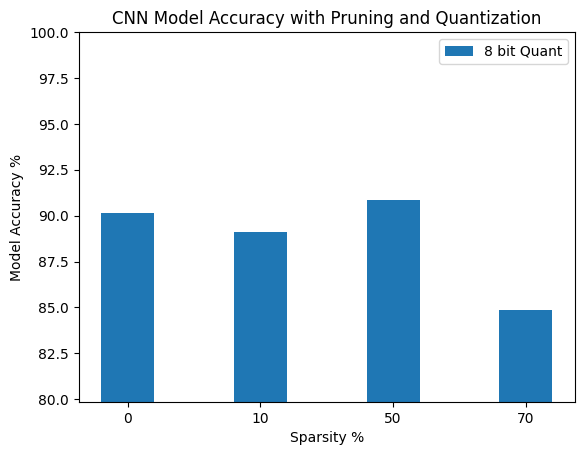

In [ ]:
target_sparsity = ["0", "10", "50", "70"]

# used for plotting multiple bars on one graph
X_axis = np.arange(len(target_sparsity))

q8 = plt.bar(X_axis, cnn_model_accuracy_q8, 0.4)

# plot specifications
plt.xticks(X_axis, target_sparsity)
plt.xlabel('Sparsity %')
plt.ylabel('Model Accuracy %')
plt.legend(('8 bit Quant',))
plt.title('CNN Model Accuracy with Pruning and Quantization')
plt.ylim((min(cnn_model_accuracy_q8)-5, 100));


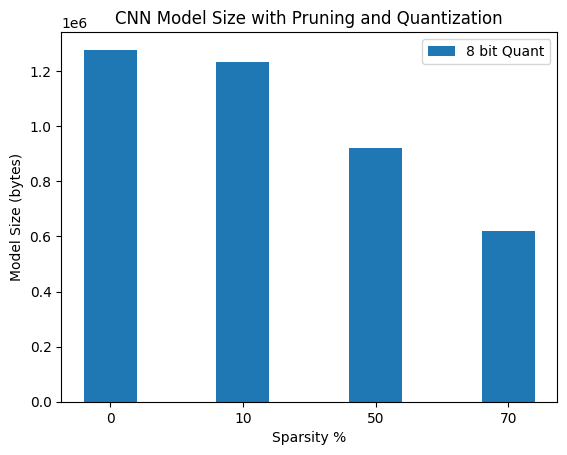

In [ ]:
# used for plotting multiple bars on one graph
X_axis = np.arange(len(target_sparsity))

q8 = plt.bar(X_axis, cnn_model_size_q8, 0.4)

# plot specifications
plt.xticks(X_axis, target_sparsity)
plt.xlabel('Sparsity %')
plt.ylabel('Model Size (bytes)')
plt.title('CNN Model Size with Pruning and Quantization')
plt.legend(('8 bit Quant',));

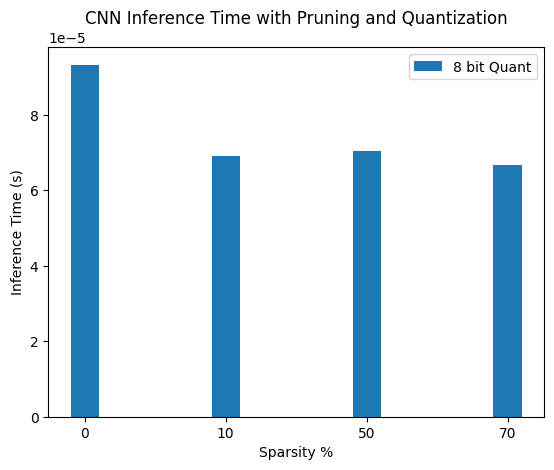

In [ ]:
# used for plotting multiple bars on one graph
X_axis = np.arange(len(target_sparsity))

q8 = plt.bar(X_axis, cnn_model_time_q8, 0.2)

# plot specifications
plt.xticks(X_axis, target_sparsity)
plt.xlabel('Sparsity %')
plt.ylabel('Inference Time (s)')
plt.title('CNN Inference Time with Pruning and Quantization')
plt.legend(('8 bit Quant',));
# plt.yscale('log')

# Iterative Prune

In [ ]:
def iterative_pruning(model, initial_sparsity, final_sparsity, begin_step, end_step, train_images, train_labels, test_images, test_labels, epochs):
  prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

  # Define model for pruning.
  pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=initial_sparsity,
        final_sparsity=final_sparsity, begin_step=begin_step, end_step=end_step, frequency=10)
  }

  pruned_model = prune_low_magnitude(model, **pruning_params)

  # `prune_low_magnitude` requires a recompile.
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
  pruned_model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])


  callbacks = [
    tfmot.sparsity.keras.UpdatePruningStep(),
  ]

  pruned_model.fit(train_images_shuffled, train_labels_indexed_shuffled, epochs=4,
                    validation_data=(test_images, test_labels_indexed),
                  callbacks=callbacks)

  # Strip pruning wrappers
  stripped_pruned_model = tfmot.sparsity.keras.strip_pruning(pruned_model)

  return pruned_model, stripped_pruned_model

In [ ]:
def print_model_weights_sparsity(model):

    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.Wrapper):
            weights = layer.trainable_weights
        else:
            weights = layer.weights
        for weight in weights:
            if "kernel" not in weight.name or "centroid" in weight.name:
                continue
            weight_size = weight.numpy().size
            zero_num = np.count_nonzero(weight == 0)
            print(
                f"{weight.name}: {zero_num/weight_size:.2%} sparsity ",
                f"({zero_num}/{weight_size})",
            )

In [ ]:
# load in model
model = tf.keras.models.load_model('trained_cnn_model_5let.h5')

# set iterative pruning specifications
initial_sparsity = 0
final_sparsity = [0.1,0.5,0.7]
begin_step = 0
end_step = 80
epochs = 4

# call each iterative pruning function
iterative_pruned_10_model = iterative_pruning(model, initial_sparsity, final_sparsity[0], begin_step, end_step, train_images_shuffled, train_labels_indexed_shuffled, test_images, test_labels, epochs)
model = tf.keras.models.load_model('trained_cnn_model_5let.h5')
iterative_pruned_50_model = iterative_pruning(model, initial_sparsity, final_sparsity[1], begin_step, end_step, train_images_shuffled, train_labels_indexed_shuffled, test_images, test_labels, epochs)
model = tf.keras.models.load_model('trained_cnn_model_5let.h5')
iterative_pruned_70_model = iterative_pruning(model, initial_sparsity, final_sparsity[2], begin_step, end_step, train_images_shuffled, train_labels_indexed_shuffled, test_images, test_labels, epochs)

# verify sparsity
print_model_weights_sparsity(iterative_pruned_10_model[1])
print_model_weights_sparsity(iterative_pruned_50_model[1])
print_model_weights_sparsity(iterative_pruned_70_model[1])

# save models
iterative_pruned_10_model[1].save('iterative_pruned_10_model.h5')
iterative_pruned_50_model[1].save('iterative_pruned_50_model.h5')
iterative_pruned_70_model[1].save('iterative_pruned_70_model.h5')

Epoch 1/4


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


36/36 [==============================] - 12s 232ms/step - loss: 0.9566 - accuracy: 0.7061 - val_loss: 0.7840 - val_accuracy: 0.7711
Epoch 2/4
36/36 [==============================] - 2s 48ms/step - loss: 0.3566 - accuracy: 0.8948 - val_loss: 0.5959 - val_accuracy: 0.8732
Epoch 3/4
36/36 [==============================] - 2s 44ms/step - loss: 0.1939 - accuracy: 0.9417 - val_loss: 0.5777 - val_accuracy: 0.8803
Epoch 4/4
36/36 [==============================] - 2s 43ms/step - loss: 0.1129 - accuracy: 0.9687 - val_loss: 0.6776 - val_accuracy: 0.8979
Epoch 1/4
 5/36 [===>..........................] - ETA: 1s - loss: 2.3382 - accuracy: 0.7000

36/36 [==============================] - 6s 63ms/step - loss: 1.0518 - accuracy: 0.7052 - val_loss: 0.8008 - val_accuracy: 0.7218
Epoch 2/4
36/36 [==============================] - 2s 44ms/step - loss: 0.7607 - accuracy: 0.7313 - val_loss: 0.6967 - val_accuracy: 0.7711
Epoch 3/4
36/36 [==============================] - 2s 44ms/step - loss: 0.3477 - accuracy: 0.8939 - val_loss: 0.4992 - val_accuracy: 0.8662
Epoch 4/4
36/36 [==============================] - 2s 46ms/step - loss: 0.1814 - accuracy: 0.9548 - val_loss: 0.4767 - val_accuracy: 0.9049
Epoch 1/4
 6/36 [====>.........................] - ETA: 1s - loss: 1.5334 - accuracy: 0.6771

36/36 [==============================] - 6s 64ms/step - loss: 0.8374 - accuracy: 0.7470 - val_loss: 0.7458 - val_accuracy: 0.7570
Epoch 2/4
36/36 [==============================] - 2s 46ms/step - loss: 0.9768 - accuracy: 0.6713 - val_loss: 1.1568 - val_accuracy: 0.5704
Epoch 3/4
36/36 [==============================] - 2s 52ms/step - loss: 0.6741 - accuracy: 0.7878 - val_loss: 0.7498 - val_accuracy: 0.8275
Epoch 4/4
36/36 [==============================] - 2s 46ms/step - loss: 0.3215 - accuracy: 0.9174 - val_loss: 0.6148 - val_accuracy: 0.8592


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


conv2d/kernel:0: 9.95% sparsity  (86/864)
conv2d_1/kernel:0: 10.00% sparsity  (1843/18432)
conv2d_2/kernel:0: 10.00% sparsity  (3686/36864)
dense/kernel:0: 10.00% sparsity  (162509/1625088)
dense_1/kernel:0: 10.00% sparsity  (24/240)
conv2d/kernel:0: 50.00% sparsity  (432/864)
conv2d_1/kernel:0: 50.00% sparsity  (9216/18432)
conv2d_2/kernel:0: 50.00% sparsity  (18432/36864)
dense/kernel:0: 50.00% sparsity  (812544/1625088)
dense_1/kernel:0: 50.00% sparsity  (120/240)
conv2d/kernel:0: 70.02% sparsity  (605/864)
conv2d_1/kernel:0: 70.00% sparsity  (12902/18432)
conv2d_2/kernel:0: 70.00% sparsity  (25805/36864)
dense/kernel:0: 70.00% sparsity  (1137562/1625088)
dense_1/kernel:0: 70.00% sparsity  (168/240)


In [ ]:
# Evaluate prediction accuracy
lenet_5_model = tf.keras.models.load_model('trained_cnn_model_5let.h5')
test_loss, test_acc = lenet_5_model.evaluate(test_images,  test_labels_indexed, verbose=0)
test_loss_pruned_10, test_acc_pruned_10 = iterative_pruned_10_model[0].evaluate(test_images,  test_labels_indexed, verbose=0)
test_loss_pruned_50, test_acc_pruned_50 = iterative_pruned_50_model[0].evaluate(test_images,  test_labels_indexed, verbose=0)
test_loss_pruned_70, test_acc_pruned_70 = iterative_pruned_70_model[0].evaluate(test_images,  test_labels_indexed, verbose=0)


# Evaluate Model Size
def get_gzipped_model_size(file):
  # Returns size of gzipped model, in bytes.
  import os
  import zipfile

  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  return os.path.getsize(zipped_file)


# Evaluate Inference Time
startTime = time.time()
prediction = lenet_5_model.predict(test_images)
executionTime = (time.time() - startTime)/len(test_images)

startTime = time.time()
prediction10 = iterative_pruned_10_model[0].predict(test_images)
executionTimePruned10 = (time.time() - startTime)/len(test_images)

startTime = time.time()
prediction50 = iterative_pruned_50_model[0].predict(test_images)
executionTimePruned50 = (time.time() - startTime)/len(test_images)

startTime = time.time()
prediction70 = iterative_pruned_70_model[0].predict(test_images)
executionTimePruned70 = (time.time() - startTime)/len(test_images)

base_model_size = get_gzipped_model_size('untrained_cnn_model.h5')
## Print without stripping
pruned_model_size_10 = get_gzipped_model_size('iterative_pruned_10_model.h5')
pruned_model_size_50 = get_gzipped_model_size('iterative_pruned_50_model.h5')
pruned_model_size_70 = get_gzipped_model_size('iterative_pruned_70_model.h5')

# Print
print('\nBase Model Accuracy:', test_acc*100, '%')
print("Base Model Size: %.2f bytes" % (base_model_size))
print("Base Inference Time is", executionTime, "s")

base_model_vector = [test_acc*100, base_model_size, executionTime]
prune_model10_vector = [test_acc_pruned_10*100, pruned_model_size_10, executionTimePruned10]
prune_model50_vector = [test_acc_pruned_50*100, pruned_model_size_50, executionTimePruned50]
prune_model70_vector = [test_acc_pruned_70*100, pruned_model_size_70, executionTimePruned70]

print('\nPruned 10 Model Accuracy:', test_acc_pruned_10*100, '%')
print("Pruned 10 Model Size: %.2f bytes" % (pruned_model_size_10))
print("Pruned 10 Inference Time is", executionTimePruned10, "s")

print('\nPruned 50 Model Accuracy:', test_acc_pruned_50*100, '%')
print("Pruned 50 Model Size: %.2f bytes" % (pruned_model_size_50))
print("Pruned 50 Inference Time is", executionTimePruned50, "s")

print('\nPruned 70 Model Accuracy:', test_acc_pruned_70*100, '%')
print("Pruned 70 Model Size: %.2f bytes" % (pruned_model_size_70))
print("Pruned 70 Inference Time is", executionTimePruned70, "s")

/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


9/9 [==============================] - 0s 14ms/step

Base Model Accuracy: 90.14084339141846 %
Base Model Size: 6168725.00 bytes
Base Inference Time is 0.0023031310296394458 s

Pruned 10 Model Accuracy: 89.78873491287231 %
Pruned 10 Model Size: 5862794.00 bytes
Pruned 10 Inference Time is 0.0026869689914542183 s

Pruned 50 Model Accuracy: 90.49295783042908 %
Pruned 50 Model Size: 3820194.00 bytes
Pruned 50 Inference Time is 0.002629866902257355 s

Pruned 70 Model Accuracy: 85.91549396514893 %
Pruned 70 Model Size: 2628998.00 bytes
Pruned 70 Inference Time is 0.0026559880082036406 s


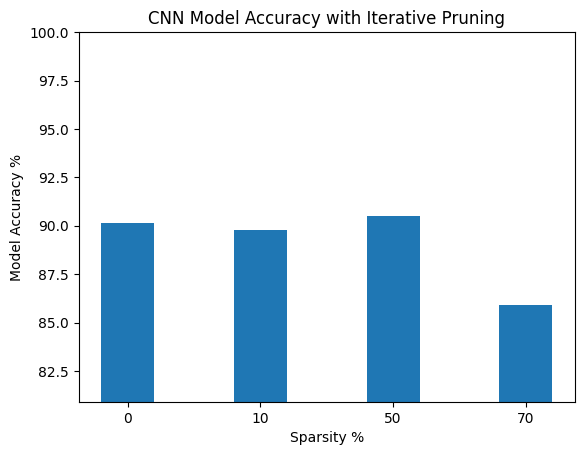

In [ ]:
import matplotlib.pyplot as plt
iterative_pruned_model_accuracy = [test_acc*100,test_acc_pruned_10*100,test_acc_pruned_50*100,test_acc_pruned_70*100]

# Model Acc
target_sparsity = ["0", "10", "50", "70"]

# used for plotting multiple bars on one graph
X_axis = np.arange(len(target_sparsity))

q8 = plt.bar(X_axis, iterative_pruned_model_accuracy, 0.4)

# plot specifications
plt.xticks(X_axis, target_sparsity)
plt.xlabel('Sparsity %')
plt.ylabel('Model Accuracy %')
plt.title('CNN Model Accuracy with Iterative Pruning')
plt.ylim((min(iterative_pruned_model_accuracy)-5, 100));

Text(0.5, 1.0, 'CNN Model Size with Iterative Pruning')

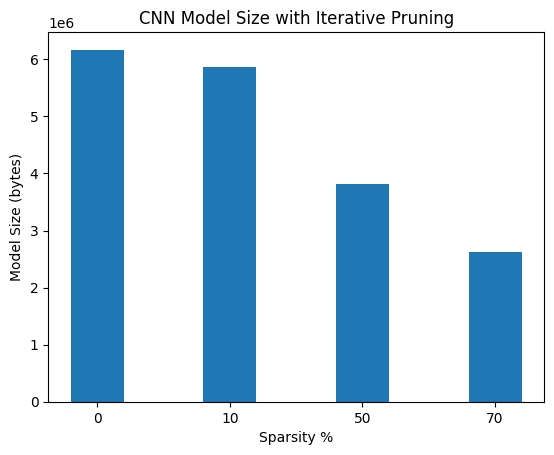

In [ ]:
iterative_pruned_model_size = [base_model_size,pruned_model_size_10,pruned_model_size_50,pruned_model_size_70]

# Model Acc
target_sparsity = ["0", "10", "50", "70"]

# used for plotting multiple bars on one graph
X_axis = np.arange(len(target_sparsity))

q8 = plt.bar(X_axis, iterative_pruned_model_size, 0.4)

# plot specifications
plt.xticks(X_axis, target_sparsity)
plt.xlabel('Sparsity %')
plt.ylabel('Model Size (bytes)')
plt.title('CNN Model Size with Iterative Pruning')
# plt.ylim((min(iterative_pruned_model_accuracy)-5, 100));

Text(0.5, 1.0, 'CNN Model Inference Time with Iterative Pruning')

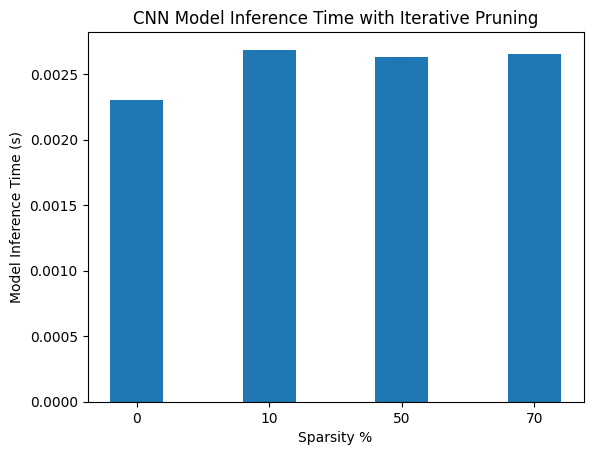

In [ ]:
iterative_pruned_model_time = [executionTime,executionTimePruned10,executionTimePruned50,executionTimePruned70]

# Model Acc
target_sparsity = ["0", "10", "50", "70"]

# used for plotting multiple bars on one graph
X_axis = np.arange(len(target_sparsity))

q8 = plt.bar(X_axis, iterative_pruned_model_time, 0.4)

# plot specifications
plt.xticks(X_axis, target_sparsity)
plt.xlabel('Sparsity %')
plt.ylabel('Model Inference Time (s)')
plt.title('CNN Model Inference Time with Iterative Pruning')
# plt.ylim((min(iterative_pruned_model_accuracy)-5, 100));

# Quant for Iterative Pruning

In [ ]:
def prune_and_quantize(model, path_to_save):
  # if model is undergoing any quantization
  model_to_quantize = tf.keras.models.load_model(model)
  converter = tf.lite.TFLiteConverter.from_keras_model(model_to_quantize)
  converter.optimizations = [tf.lite.Optimize.DEFAULT]
  fp8_quantized_tflite_model = converter.convert()
    # when the value of quant is set to 2, compute 16 bit floating point quant.
  with open(path_to_save, 'wb') as f:
    f.write(fp8_quantized_tflite_model)
  interpreter_quant = tf.lite.Interpreter(model_path=str(path_to_save))
  interpreter_quant.allocate_tensors()

  results = evaluate_model(interpreter_quant, path_to_save)
    # store results in a data vector
  quant_data_vector.append(results)

# store each loop values
quant_data_vector = []


# no pruning
prune_and_quantize('trained_cnn_model_5let.h5', 'no_prune_fp8_quantized_tflite_model.tflite')
prune_and_quantize('iterative_pruned_10_model.h5', 'iterative_pruned_10_fp8_quantized_tflite_model.tflite')
prune_and_quantize('iterative_pruned_50_model.h5', 'iterative_pruned_50_fp8_quantized_tflite_model.tflite')
prune_and_quantize('iterative_pruned_70_model.h5', 'iterative_pruned_70_fp8_quantized_tflite_model.tflite')


Model Accuracy: 90.14084507042254 %
Model Size: 1277854.00 bytes
Inference Time is 6.832539195745764e-05 s



Model Accuracy: 90.14084507042254 %
Model Size: 1201769.00 bytes
Inference Time is 6.687305342983192e-05 s



Model Accuracy: 91.90140845070422 %
Model Size: 955818.00 bytes
Inference Time is 7.348245298358756e-05 s

Model Accuracy: 85.56338028169014 %
Model Size: 667455.00 bytes
Inference Time is 6.701576877647722e-05 s


In [ ]:
# set lists for each metric
iterative_pruned_model_acc_q8 = []
iterative_pruned_model_size_q8 = []
iterative_pruned_model_time_q8 = []


In [ ]:
# populate each list with vector values
for i in range(len(quant_data_vector)):
  iterative_pruned_model_acc_q8.append(quant_data_vector[i][0])
  iterative_pruned_model_size_q8.append(quant_data_vector[i][1])
  iterative_pruned_model_time_q8.append(quant_data_vector[i][2])

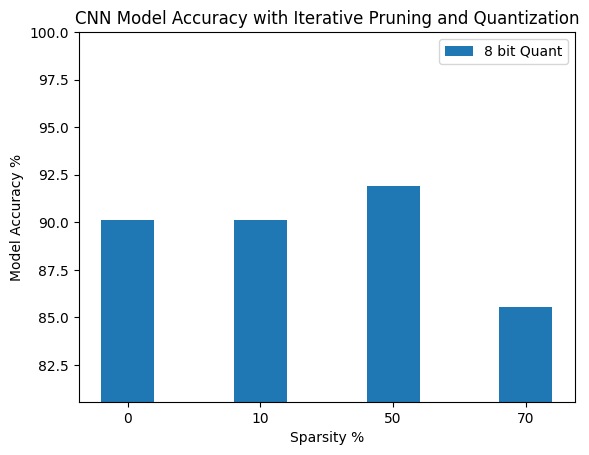

In [ ]:
target_sparsity = ["0", "10", "50", "70"]

# used for plotting multiple bars on one graph
X_axis = np.arange(len(target_sparsity))

q8 = plt.bar(X_axis, iterative_pruned_model_acc_q8, 0.4)

# plot specifications
plt.xticks(X_axis, target_sparsity)
plt.xlabel('Sparsity %')
plt.ylabel('Model Accuracy %')
plt.legend(('8 bit Quant',))
plt.title('CNN Model Accuracy with Iterative Pruning and Quantization')
plt.ylim((min(iterative_pruned_model_acc_q8)-5, 100));

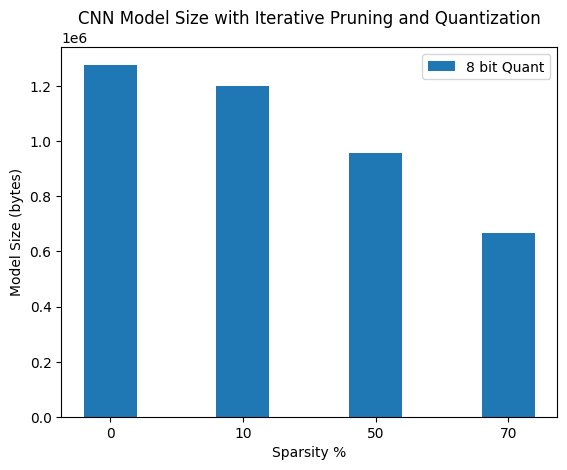

In [ ]:
q8 = plt.bar(X_axis, iterative_pruned_model_size_q8, 0.4)

# plot specifications
plt.xticks(X_axis, target_sparsity)
plt.xlabel('Sparsity %')
plt.ylabel('Model Size (bytes)')
plt.legend(('8 bit Quant',))
plt.title('CNN Model Size with Iterative Pruning and Quantization');

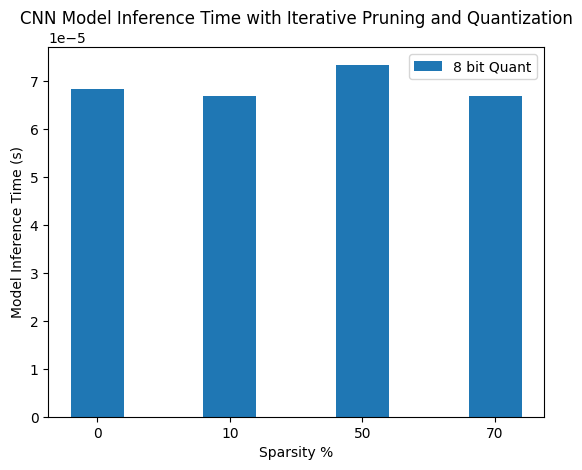

In [ ]:
q8 = plt.bar(X_axis, iterative_pruned_model_time_q8, 0.4)

# plot specifications
plt.xticks(X_axis, target_sparsity)
plt.xlabel('Sparsity %')
plt.ylabel('Model Inference Time (s)')
plt.legend(('8 bit Quant',))
plt.title('CNN Model Inference Time with Iterative Pruning and Quantization');

# Results from CNN Architecture with Different Pruning and 8 Bit Quantization

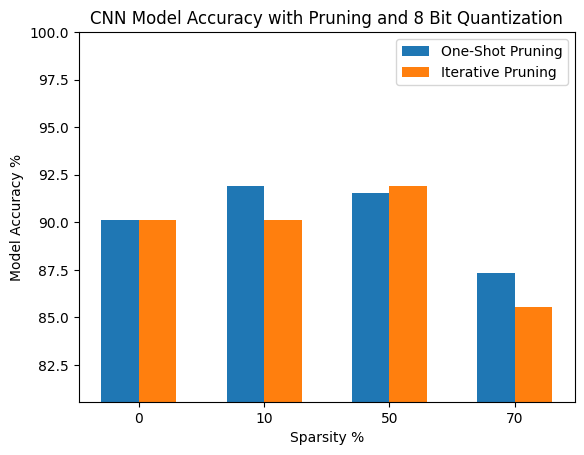

In [ ]:
target_sparsity = ["0", "10", "50", "70"]

# used for plotting multiple bars on one graph
X_axis = np.arange(len(target_sparsity))

Oneshot_prune = plt.bar(X_axis - 0.15, cnn_model_accuracy_q8, 0.3)
Iter_prune = plt.bar(X_axis + 0.15, iterative_pruned_model_acc_q8, 0.3)

# plot specifications
plt.xticks(X_axis, target_sparsity)
plt.xlabel('Sparsity %')
plt.ylabel('Model Accuracy %')
plt.legend((Oneshot_prune,Iter_prune),('One-Shot Pruning','Iterative Pruning'))
plt.title('CNN Model Accuracy with Pruning and 8 Bit Quantization')
plt.ylim((min(iterative_pruned_model_acc_q8)-5, 100));

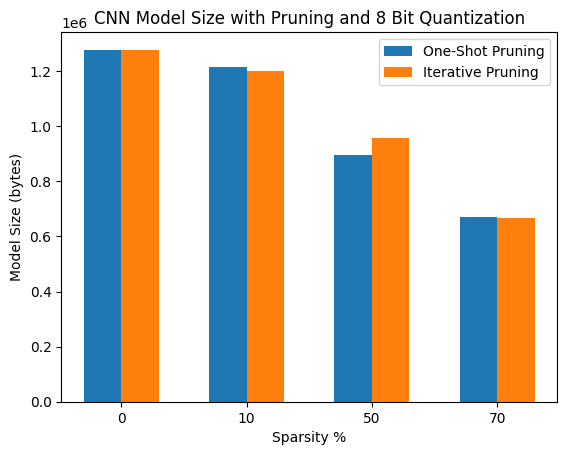

In [ ]:
target_sparsity = ["0", "10", "50", "70"]

# used for plotting multiple bars on one graph
X_axis = np.arange(len(target_sparsity))

Oneshot_prune = plt.bar(X_axis - 0.15, cnn_model_size_q8, 0.3)
Iter_prune = plt.bar(X_axis + 0.15, iterative_pruned_model_size_q8, 0.3)

# plot specifications
plt.xticks(X_axis, target_sparsity)
plt.xlabel('Sparsity %')
plt.ylabel('Model Size (bytes)')
plt.legend((Oneshot_prune,Iter_prune),('One-Shot Pruning','Iterative Pruning'))
plt.title('CNN Model Size with Pruning and 8 Bit Quantization');
# plt.ylim((min(iterative_pruned_model_size_q8)-5, 100));

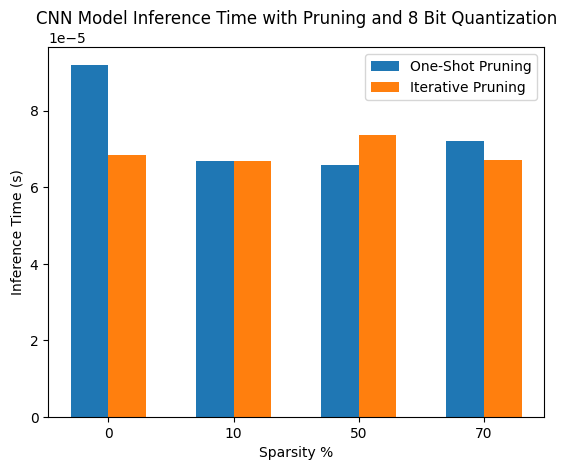

In [ ]:
target_sparsity = ["0", "10", "50", "70"]

# used for plotting multiple bars on one graph
X_axis = np.arange(len(target_sparsity))

Oneshot_prune = plt.bar(X_axis - 0.15, cnn_model_time_q8, 0.3)
Iter_prune = plt.bar(X_axis + 0.15, iterative_pruned_model_time_q8, 0.3)

# plot specifications
plt.xticks(X_axis, target_sparsity)
plt.xlabel('Sparsity %')
plt.ylabel('Inference Time (s)')
plt.legend((Oneshot_prune,Iter_prune),('One-Shot Pruning','Iterative Pruning'))
plt.title('CNN Model Inference Time with Pruning and 8 Bit Quantization');

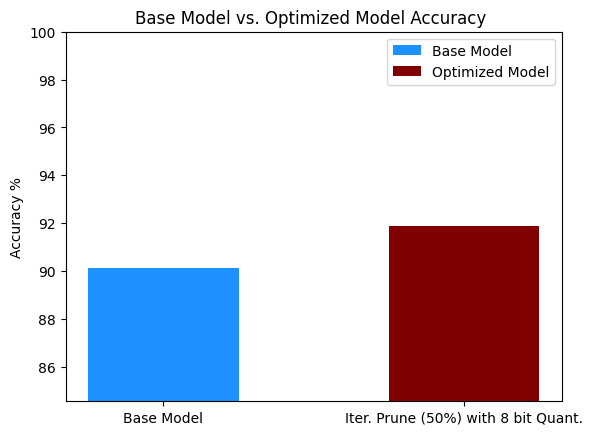

In [ ]:
# used for plotting multiple bars on one graph
x_string = ['Base Model', 'Iter. Prune (50%) with 8 bit Quant.']
acc_results = [base_model_vector[0], iterative_pruned_model_acc_q8[2]]
bar_colors = ['dodgerblue', 'maroon']
X_axis = np.arange(len(acc_results))

# plot specifications
base_model_bar = plt.bar(x_string[0], acc_results[0], color = bar_colors[0], width = 0.5)
new_model_bar = plt.bar(x_string[1], acc_results[1], color = bar_colors[1], width = 0.5)

plt.ylabel('Accuracy %')
plt.legend((base_model_bar, new_model_bar),('Base Model','Optimized Model'))
plt.title('Base Model vs. Optimized Model Accuracy ')
plt.ylim((min(iterative_pruned_model_acc_q8)-1, 100));

9/9 [==============================] - 0s 18ms/step


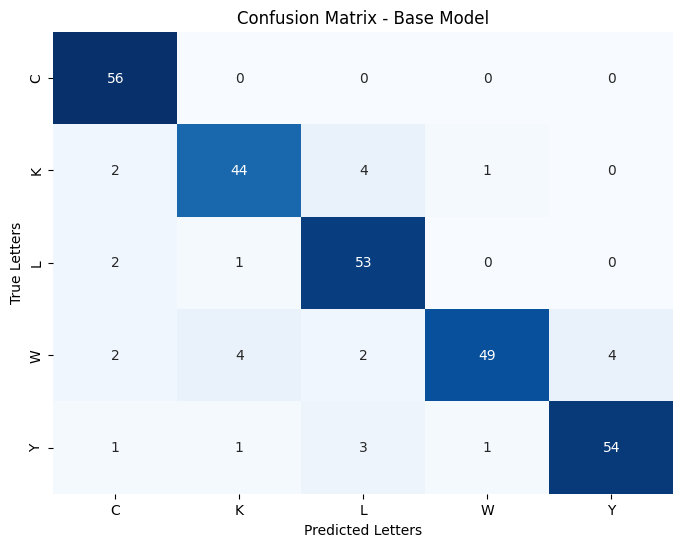

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# load in model
base_model = tf.keras.models.load_model('trained_cnn_model_5let.h5')

# get prediction
predicted_letters = base_model.predict(test_images)
predicted_letters = np.argmax(predicted_letters, axis=1)

# generate confusion matrix (base model)
conf_matrix = confusion_matrix(test_labels_indexed, predicted_letters)

# plot specifications
label_names = ['C','K','L','W','Y']
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=label_names, yticklabels=label_names)
plt.xlabel("Predicted Letters")
plt.ylabel("True Letters")
plt.title("Confusion Matrix - Base Model")
plt.show()

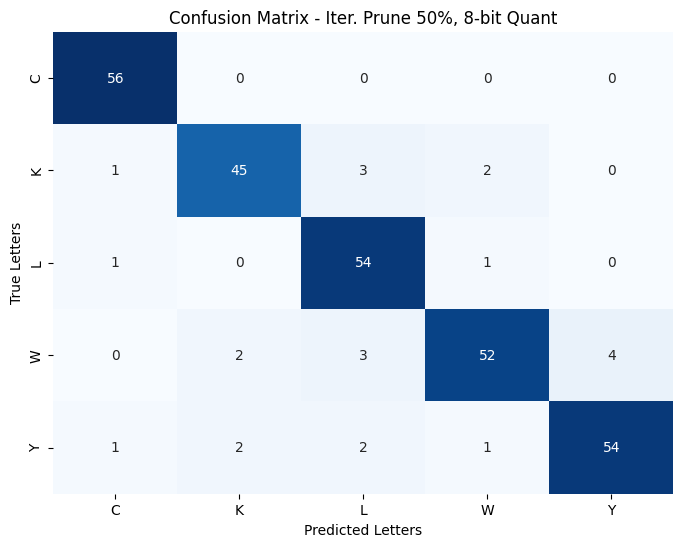

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# load in tflite model
interpreter_quant = tf.lite.Interpreter(model_path='iterative_pruned_50_fp8_quantized_tflite_model.tflite')
interpreter_quant.allocate_tensors()
input_index = interpreter_quant.get_input_details()[0]['index']
output_index = interpreter_quant.get_output_details()[0]['index']

# make list and populate with predictions
predicted_letters = []
for image in test_images:

    image = np.expand_dims(image, axis=0).astype(np.float32)
    interpreter_quant.set_tensor(input_index, image)

    interpreter_quant.invoke()
    output = interpreter_quant.tensor(output_index)
    digit = np.argmax(output()[0])
    predicted_letters.append(digit)

# generate confusion matrix
conf_matrix = confusion_matrix(test_labels_indexed, predicted_letters)

# plot specifications
label_names = ['C','K','L','W','Y']
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=label_names, yticklabels=label_names)
plt.xlabel("Predicted Letters")
plt.ylabel("True Letters")
plt.title("Confusion Matrix - Iter. Prune 50%, 8-bit Quant")
plt.show()

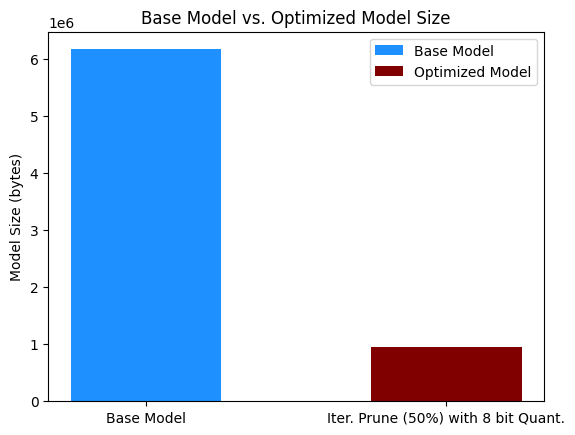

In [ ]:
# used for plotting multiple bars on one graph
size_results = [base_model_vector[1], iterative_pruned_model_size_q8[2]]
bar_colors = ['dodgerblue', 'maroon']
X_axis = np.arange(len(acc_results))

# plot specifications
base_model_bar = plt.bar(x_string[0], size_results[0], color = bar_colors[0], width = 0.5)
new_model_bar = plt.bar(x_string[1], size_results[1], color = bar_colors[1], width = 0.5)

plt.ylabel('Model Size (bytes)')
plt.legend((base_model_bar, new_model_bar),('Base Model','Optimized Model'))
plt.title('Base Model vs. Optimized Model Size');

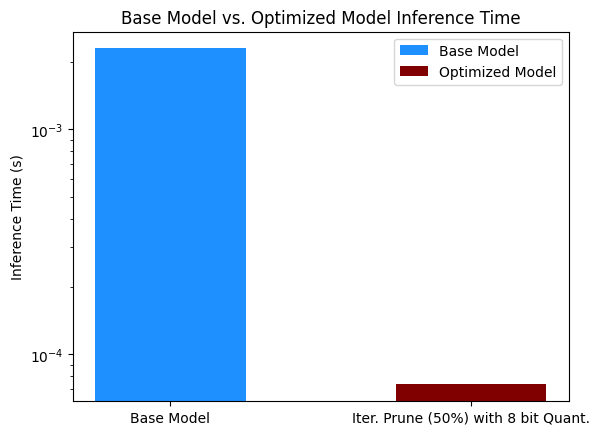

In [ ]:
# used for plotting multiple bars on one graph
size_results = [base_model_vector[2], iterative_pruned_model_time_q8[2]]
bar_colors = ['dodgerblue', 'maroon']
X_axis = np.arange(len(acc_results))

# plot specifications
base_model_bar = plt.bar(x_string[0], size_results[0], color = bar_colors[0], width = 0.5)
new_model_bar = plt.bar(x_string[1], size_results[1], color = bar_colors[1], width = 0.5)

plt.ylabel('Inference Time (s)')
plt.legend((base_model_bar, new_model_bar),('Base Model','Optimized Model'))
plt.title('Base Model vs. Optimized Model Inference Time');
plt.yscale('log')

# Weight-Clustering with iterative 50% model + post training quantization

In [ ]:
# Clustering
def sparse_preserve_cluster(stripped_pruned_model,n_clusters):
    cluster_weights = tfmot.clustering.keras.cluster_weights
    CentroidInitialization = tfmot.clustering.keras.CentroidInitialization

    # Sparsity preserving clustering
    from tensorflow_model_optimization.python.core.clustering.keras.experimental import (
        cluster,
    )

    cluster_weights = cluster.cluster_weights

    # clustering parameters
    clustering_params = {
    'number_of_clusters': n_clusters,
    'cluster_centroids_init': CentroidInitialization.KMEANS_PLUS_PLUS,
    'preserve_sparsity': True
    }

    sparsity_clustered_model = cluster_weights(stripped_pruned_model, **clustering_params)

    sparsity_clustered_model.compile(optimizer='adam',
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

    print('Train sparsity preserving clustering model:')
    sparsity_clustered_model.fit(train_images, train_labels_indexed,epochs=2, validation_data=(test_images, test_labels_indexed))
    return sparsity_clustered_model

In [ ]:
# set n clusters
n_clusters = [3,5,8]
# load in desired model
stripped_iterative_prune_50_model = tf.keras.models.load_model('iterative_pruned_50_model.h5')

# cluster model and save new model
sparsity_clustered_3_model = sparse_preserve_cluster(stripped_iterative_prune_50_model,3)
sparsity_clustered_3_model.save('sparsity_clustered_model_3.h5')

stripped_iterative_prune_50_model = tf.keras.models.load_model('iterative_pruned_50_model.h5')
sparsity_clustered_5_model = sparse_preserve_cluster(stripped_iterative_prune_50_model,5)
sparsity_clustered_5_model.save('sparsity_clustered_model_5.h5')

stripped_iterative_prune_50_model = tf.keras.models.load_model('iterative_pruned_50_model.h5')
sparsity_clustered_8_model = sparse_preserve_cluster(stripped_iterative_prune_50_model,8)
sparsity_clustered_8_model.save('sparsity_clustered_model_8.h5')

Train sparsity preserving clustering model:
Epoch 1/2
36/36 [==============================] - 109s 3s/step - loss: 0.4133 - accuracy: 0.8861 - val_loss: 0.5719 - val_accuracy: 0.8908
Epoch 2/2
36/36 [==============================] - 104s 3s/step - loss: 0.1346 - accuracy: 0.9609 - val_loss: 0.5003 - val_accuracy: 0.8908


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Train sparsity preserving clustering model:
Epoch 1/2
36/36 [==============================] - 110s 3s/step - loss: 0.1493 - accuracy: 0.9609 - val_loss: 0.6671 - val_accuracy: 0.8908
Epoch 2/2
36/36 [==============================] - 104s 3s/step - loss: 0.0958 - accuracy: 0.9696 - val_loss: 0.8602 - val_accuracy: 0.9014


Train sparsity preserving clustering model:
Epoch 1/2
36/36 [==============================] - 111s 3s/step - loss: 0.1475 - accuracy: 0.9513 - val_loss: 0.5817 - val_accuracy: 0.9120
Epoch 2/2
36/36 [==============================] - 131s 4s/step - loss: 0.1120 - accuracy: 0.9687 - val_loss: 0.8645 - val_accuracy: 0.9155


In [ ]:
# strip clustering and save model
stripped_sparsity_clustered_3_model = tfmot.clustering.keras.strip_clustering(sparsity_clustered_3_model)
stripped_sparsity_clustered_3_model.save('stripped_sparsity_clustered_3_model.h5')
stripped_sparsity_clustered_5_model = tfmot.clustering.keras.strip_clustering(sparsity_clustered_5_model)
stripped_sparsity_clustered_5_model.save('stripped_sparsity_clustered_5_model.h5')
stripped_sparsity_clustered_8_model = tfmot.clustering.keras.strip_clustering(sparsity_clustered_8_model)
stripped_sparsity_clustered_8_model.save('stripped_sparsity_clustered_8_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/__init__.py:144: UserWarning: The `keras.initializers.serialize()` API should only be used for objects of type `keras.initializers.Initializer`. Found an instance of type <class 'tf_keras.src.initializers.initializers.GlorotUniform'>, which may lead to improper serialization.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/initializers/__init__.py:144: UserWarning: The `keras.initializers.serialize()` API should only be used for objects of type `keras.initializers.Initializer`. Found an instance of type <class 'tf_keras.src.initializers.initializers.Zeros'>, which may lead to improper serialization.
  warnings.warn(


In [ ]:
# Evaluate prediction accuracy
test_loss_sparsity_clustered_3, test_acc_sparsity_clustered_3 = sparsity_clustered_3_model.evaluate(test_images,  test_labels_indexed, verbose=0)
test_loss_sparsity_clustered_5, test_acc_sparsity_clustered_5 = sparsity_clustered_5_model.evaluate(test_images,  test_labels_indexed, verbose=0)
test_loss_sparsity_clustered_8, test_acc_sparsity_clustered_8 = sparsity_clustered_8_model.evaluate(test_images,  test_labels_indexed, verbose=0)
# Evaluate Model Size
def get_gzipped_model_size(file):
  # Returns size of gzipped model, in bytes.
  import os
  import zipfile

  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  return os.path.getsize(zipped_file)


# Evaluate Inference Time

startTime = time.time()
prediction_3 = sparsity_clustered_3_model.predict(test_images)
executionTimeSparsityClustered3 = (time.time() - startTime)/len(test_images)
startTime = time.time()

prediction_5 = sparsity_clustered_5_model.predict(test_images)
executionTimeSparsityClustered5 = (time.time() - startTime)/len(test_images)
startTime = time.time()

prediction_8 = sparsity_clustered_8_model.predict(test_images)
executionTimeSparsityClustered8 = (time.time() - startTime)/len(test_images)

## Print without stripping
sparsity_clustered_3_model_size = get_gzipped_model_size('stripped_sparsity_clustered_3_model.h5')
sparsity_clustered_5_model_size = get_gzipped_model_size('stripped_sparsity_clustered_5_model.h5')
sparsity_clustered_8_model_size = get_gzipped_model_size('stripped_sparsity_clustered_8_model.h5')

# Print
print('\nSparsity Clustered 3 Model Accuracy:', test_acc_sparsity_clustered_3*100, '%')
print("Sparsity Clustered 3 Model Size: %.2f bytes" % (sparsity_clustered_3_model_size))
print("Sparsity Clustered 3 Inference Time is", executionTimeSparsityClustered3, "s")

print('\nSparsity Clustered 5 Model Accuracy:', test_acc_sparsity_clustered_5*100, '%')
print("Sparsity Clustered 5 Model Size: %.2f bytes" % (sparsity_clustered_5_model_size))
print("Sparsity Clustered 5 Inference Time is", executionTimeSparsityClustered5, "s")

print('\nSparsity Clustered 8 Model Accuracy:', test_acc_sparsity_clustered_8*100, '%')
print("Sparsity Clustered 8 Model Size: %.2f bytes" % (sparsity_clustered_8_model_size))
print("Sparsity Clustered 8 Inference Time is", executionTimeSparsityClustered8, "s")

9/9 [==============================] - 7s 734ms/step

Sparsity Clustered 3 Model Accuracy: 89.08450603485107 %
Sparsity Clustered 3 Model Size: 528417.00 bytes
Sparsity Clustered 3 Inference Time is 0.037799130862867326 s

Sparsity Clustered 5 Model Accuracy: 90.14084339141846 %
Sparsity Clustered 5 Model Size: 585830.00 bytes
Sparsity Clustered 5 Inference Time is 0.03730077474889621 s

Sparsity Clustered 8 Model Accuracy: 91.54929518699646 %
Sparsity Clustered 8 Model Size: 702740.00 bytes
Sparsity Clustered 8 Inference Time is 0.03722444470499603 s


In [ ]:
def print_model_weights_sparsity(model):

    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.Wrapper):
            weights = layer.trainable_weights
        else:
            weights = layer.weights
        for weight in weights:
            if "kernel" not in weight.name or "centroid" in weight.name:
                continue
            weight_size = weight.numpy().size
            zero_num = np.count_nonzero(weight == 0)
            print(
                f"{weight.name}: {zero_num/weight_size:.2%} sparsity ",
                f"({zero_num}/{weight_size})",
            )
stripped_iterative_prune_50_model = tf.keras.models.load_model('stripped_sparsity_clustered_3_model.h5')
print_model_weights_sparsity(stripped_iterative_prune_50_model)
# check to make sure sparsity is maintained:

conv2d/kernel:0: 50.69% sparsity  (438/864)
conv2d_1/kernel:0: 52.67% sparsity  (9709/18432)
conv2d_2/kernel:0: 53.13% sparsity  (19587/36864)
dense/kernel:0: 64.61% sparsity  (1049905/1625088)
dense_1/kernel:0: 50.00% sparsity  (120/240)


In [ ]:
# Evaluate Model Size
def get_gzipped_model_size(file):
  # Returns size of gzipped model, in bytes.
  import os
  import zipfile

  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  return os.path.getsize(zipped_file)

# A helper function to evaluate the TF Lite model using "test" dataset.
def evaluate_model(interpreter, model_path):
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]

  # Run predictions on every image in the "test" dataset.
  prediction_letters = []
  for test_image in test_images:
    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
    interpreter.set_tensor(input_index, test_image)

    # Run inference.
    startTime = time.time()
    interpreter.invoke()
    executionTime = (time.time() - startTime)/len(test_images)

    # Post-processing: remove batch dimension and find the digit with highest
    # probability.
    output = interpreter.tensor(output_index)
    digit = np.argmax(output()[0])
    prediction_letters.append(digit)

  # Compare prediction results with ground truth labels to calculate accuracy.
  accurate_count = 0
  for index in range(len(prediction_letters)):
    if prediction_letters[index] == test_labels_indexed[index]:
      accurate_count += 1
  accuracy = accurate_count * 1.0 / len(prediction_letters)

  model_size = get_gzipped_model_size(model_path)
  # Print
  print('\nModel Accuracy:', accuracy*100, '%')
  print("Model Size: %.2f bytes" % (model_size))
  print("Inference Time is", executionTime, "s")
  return accuracy*100, model_size, executionTime

In [ ]:
def prune_and_quantize(model, path_to_save):
  # if model is undergoing any quantization
  model_to_quantize = tf.keras.models.load_model(model)
  converter = tf.lite.TFLiteConverter.from_keras_model(model_to_quantize)
  converter.optimizations = [tf.lite.Optimize.DEFAULT]
  fp8_quantized_tflite_model = converter.convert()

  with open(path_to_save, 'wb') as f:
    f.write(fp8_quantized_tflite_model)
  interpreter_quant = tf.lite.Interpreter(model_path=str(path_to_save))
  interpreter_quant.allocate_tensors()

  results = evaluate_model(interpreter_quant, path_to_save)
    # store results in a data vector
  quant_data_vector.append(results)
# this variable stores the quantization data
quant_data_vector = []
# no pruning
prune_and_quantize('trained_cnn_model_5let.h5', 'no_prune_fp8_quantized_tflite_model.tflite')
prune_and_quantize('stripped_sparsity_clustered_3_model.h5', 'prune50_clustered3_fp8_quantized_tflite_model.tflite')
prune_and_quantize('stripped_sparsity_clustered_5_model.h5', 'prune50_clustered5_fp8_quantized_tflite_model.tflite')
prune_and_quantize('stripped_sparsity_clustered_8_model.h5', 'prune50_clustered8_fp8_quantized_tflite_model.tflite')


Model Accuracy: 90.14084507042254 %
Model Size: 1277854.00 bytes
Inference Time is 7.594639146831674e-05 s



Model Accuracy: 21.47887323943662 %
Model Size: 362418.00 bytes
Inference Time is 8.108414394754759e-05 s



Model Accuracy: 19.718309859154928 %
Model Size: 399655.00 bytes
Inference Time is 7.862692147913113e-05 s

Model Accuracy: 19.718309859154928 %
Model Size: 480179.00 bytes
Inference Time is 9.430378255709796e-05 s


In [ ]:
quant_data_vector

[(90.14084507042254, 1277854, 7.594639146831674e-05),
 (21.47887323943662, 362418, 8.108414394754759e-05),
 (19.718309859154928, 399655, 7.862692147913113e-05),
 (19.718309859154928, 480179, 9.430378255709796e-05)]

In [ ]:
def prune_and_quantize16(model, path_to_save):
  # if model is undergoing any quantization
  model_to_quantize = tf.keras.models.load_model(model)
  converter = tf.lite.TFLiteConverter.from_keras_model(model_to_quantize)
  converter.optimizations = [tf.lite.Optimize.DEFAULT]
  converter.target_spec.supported_types = [tf.float16]
  fp16_quantized_tflite_model = converter.convert()

  with open(path_to_save, 'wb') as f:
    f.write(fp16_quantized_tflite_model)
  interpreter_quant = tf.lite.Interpreter(model_path=str(path_to_save))
  interpreter_quant.allocate_tensors()

  results = evaluate_model(interpreter_quant, path_to_save)
    # store results in a data vector
  quant_data_vector_16.append(results)
# this variable stores the quantization data
quant_data_vector_16 = []

prune_and_quantize16('trained_cnn_model_5let.h5', 'no_prune_fp16_quantized_tflite_model.tflite')
prune_and_quantize16('stripped_sparsity_clustered_3_model.h5', 'prune50_clustered3_fp16_quantized_tflite_model.tflite')
prune_and_quantize16('stripped_sparsity_clustered_5_model.h5', 'prune50_clustered5_fp16_quantized_tflite_model.tflite')
prune_and_quantize16('stripped_sparsity_clustered_8_model.h5', 'prune50_clustered8_fp16_quantized_tflite_model.tflite')


Model Accuracy: 90.14084507042254 %
Model Size: 3063550.00 bytes
Inference Time is 7.50422477722168e-05 s



Model Accuracy: 89.08450704225352 %
Model Size: 426781.00 bytes
Inference Time is 3.871867354487029e-05 s



Model Accuracy: 90.14084507042254 %
Model Size: 465072.00 bytes
Inference Time is 7.225426150039888e-05 s



Model Accuracy: 91.54929577464789 %
Model Size: 563279.00 bytes
Inference Time is 3.9417978743432274e-05 s


In [ ]:
quant_data_vector_16

[(90.14084507042254, 3063550, 7.50422477722168e-05),
 (89.08450704225352, 426781, 3.871867354487029e-05),
 (90.14084507042254, 465072, 7.225426150039888e-05),
 (91.54929577464789, 563279, 3.9417978743432274e-05)]

In [ ]:
# separate data lists for graphs
cnn_model_cluster_accuracy_q8 = []
cnn_model_cluster_size_q8 = []
cnn_model_cluster_time_q8 = []

cnn_model_cluster_accuracy_q16 = []
cnn_model_cluster_size_q16 = []
cnn_model_cluster_time_q16 = []

In [ ]:
# compile data into separate vectors
for i in range(len(quant_data_vector)):
  cnn_model_cluster_accuracy_q8.append(quant_data_vector[i][0])
  cnn_model_cluster_size_q8.append(quant_data_vector[i][1])
  cnn_model_cluster_time_q8.append(quant_data_vector[i][2])

  cnn_model_cluster_accuracy_q16.append(quant_data_vector_16[i][0])
  cnn_model_cluster_size_q16.append(quant_data_vector_16[i][1])
  cnn_model_cluster_time_q16.append(quant_data_vector_16[i][2])

<Figure size 300x300 with 0 Axes>

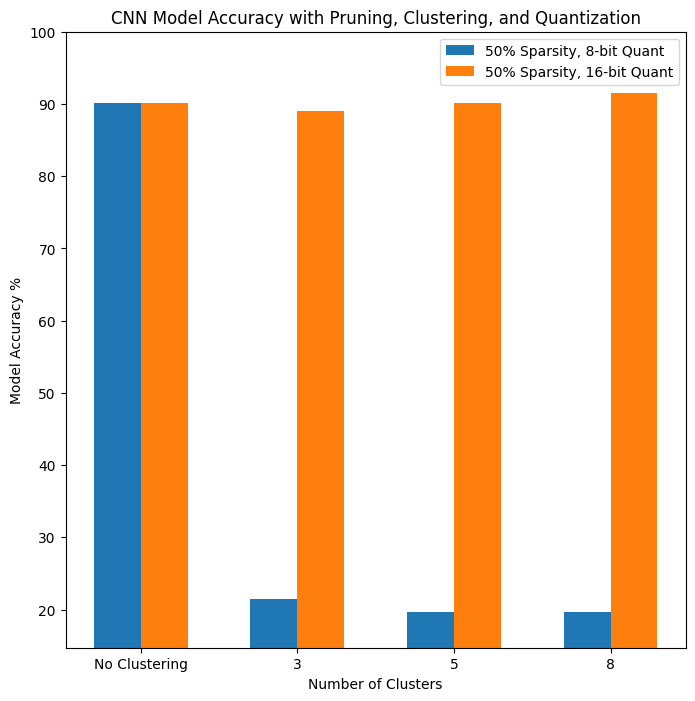

<Figure size 300x300 with 0 Axes>

In [ ]:
target_sparsity = ["No Clustering", "3", "5", "8"]

# used for plotting multiple bars on one graph
X_axis = np.arange(len(target_sparsity))

q8 = plt.bar(X_axis - 0.15, cnn_model_cluster_accuracy_q8, 0.3)
q16 = plt.bar(X_axis + 0.15, cnn_model_cluster_accuracy_q16, 0.3)


# plot specifications
plt.xticks(X_axis, target_sparsity)
plt.xlabel('Number of Clusters')
plt.ylabel('Model Accuracy %')
plt.legend((q8, q16),('50% Sparsity, 8-bit Quant', '50% Sparsity, 16-bit Quant'))
plt.title('CNN Model Accuracy with Pruning, Clustering, and Quantization')
plt.ylim((min(cnn_model_cluster_accuracy_q8)-5, 100));
plt.figure(figsize=(10, 10), dpi=30)

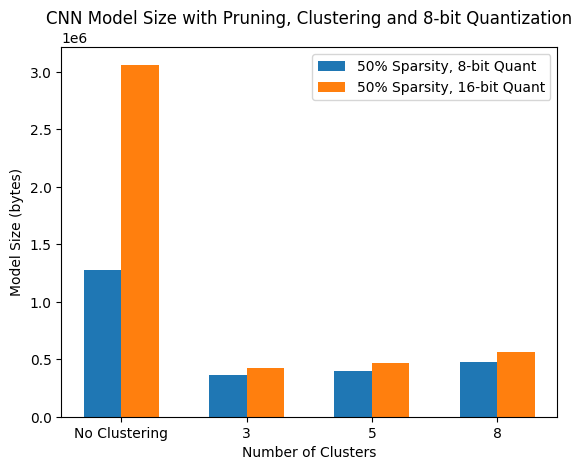

In [ ]:
target_sparsity = ["No Clustering", "3", "5", "8"]

# used for plotting multiple bars on one graph
X_axis = np.arange(len(target_sparsity))

q8 = plt.bar(X_axis - 0.15, cnn_model_cluster_size_q8, 0.3)
q16 = plt.bar(X_axis + 0.15, cnn_model_cluster_size_q16, 0.3)

# plot specifications
plt.xticks(X_axis, target_sparsity)
plt.xlabel('Number of Clusters')
plt.ylabel('Model Size (bytes)')
plt.legend((q8, q16),('50% Sparsity, 8-bit Quant', '50% Sparsity, 16-bit Quant'))
plt.title('CNN Model Size with Pruning, Clustering and 8-bit Quantization');

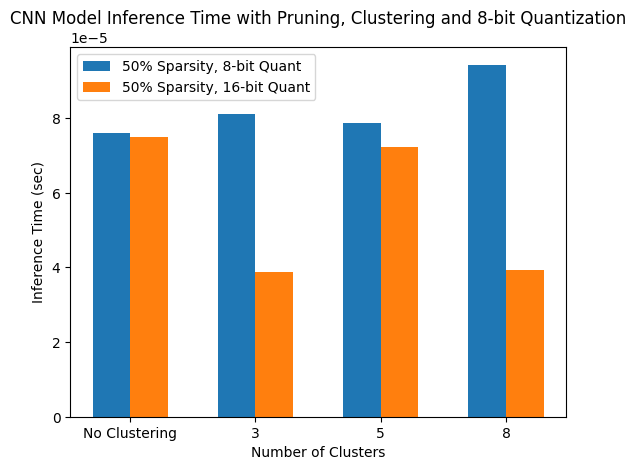

In [ ]:
target_sparsity = ["No Clustering", "3", "5", "8"]

# used for plotting multiple bars on one graph
X_axis = np.arange(len(target_sparsity))

q8 = plt.bar(X_axis - 0.15, cnn_model_cluster_time_q8, 0.3)
q16 = plt.bar(X_axis + 0.15, cnn_model_cluster_time_q16, 0.3)

plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

# plot specifications
plt.xticks(X_axis, target_sparsity)
plt.xlabel('Number of Clusters')
plt.ylabel('Inference Time (sec)')
plt.legend((q8, q16),('50% Sparsity, 8-bit Quant', '50% Sparsity, 16-bit Quant'))
plt.title('CNN Model Inference Time with Pruning, Clustering and 8-bit Quantization');

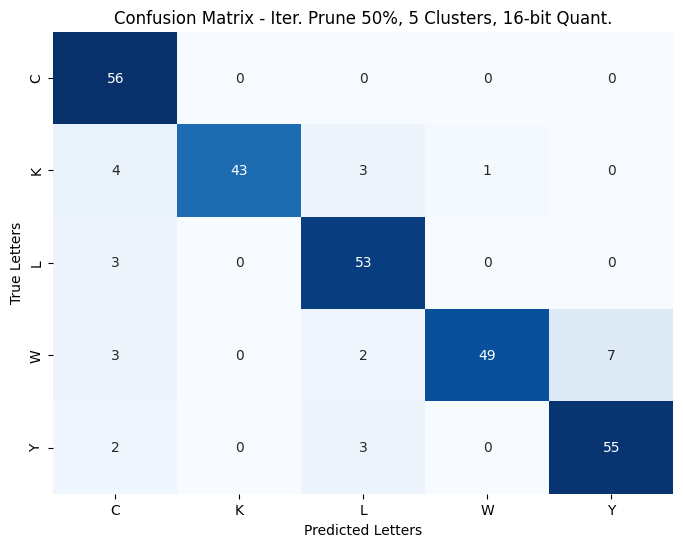

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# load in tflite model
interpreter_quant = tf.lite.Interpreter(model_path='prune50_clustered5_fp16_quantized_tflite_model.tflite')
interpreter_quant.allocate_tensors()
input_index = interpreter_quant.get_input_details()[0]['index']
output_index = interpreter_quant.get_output_details()[0]['index']

# make list and populate with predictions
predicted_letters = []
for image in test_images:

    image = np.expand_dims(image, axis=0).astype(np.float32)
    interpreter_quant.set_tensor(input_index, image)

    interpreter_quant.invoke()
    output = interpreter_quant.tensor(output_index)
    digit = np.argmax(output()[0])
    predicted_letters.append(digit)

# generate confusion matrix
conf_matrix = confusion_matrix(test_labels_indexed, predicted_letters)

# plot specifications
label_names = ['C','K','L','W','Y']
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=label_names, yticklabels=label_names)
plt.xlabel("Predicted Letters")
plt.ylabel("True Letters")
plt.title("Confusion Matrix - Iter. Prune 50%, 5 Clusters, 16-bit Quant.")
plt.show()

# Mobile-net

In [ ]:
# mobilenet model configuration
mobilenet_model = tf.keras.applications.mobilenet_v2.MobileNetV2(
    input_shape=None,
    alpha=1.0,
    include_top=False,
    weights= 'imagenet',
    input_tensor=None,
    pooling='max',
    classes=5,
    classifier_activation='softmax',
)

mobilenet_model.save('untrained_mobilenet_model.h5')

In [ ]:
mobilenet_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, None, None, 32)       864       ['input_2[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, None, None, 32)       128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, None, None, 32)       0         ['bn_Conv1[

In [ ]:
# compile and fit mobilenet model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
mobilenet_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = mobilenet_model.fit(train_images_shuffled, train_labels_indexed_shuffled, epochs=8,
                    validation_data=(test_images, test_labels_indexed))

mobilenet_model.save('trained_mobilenet_model2.h5')

Epoch 1/8
36/36 [==============================] - 29s 167ms/step - loss: 3.5476 - accuracy: 0.6070 - val_loss: 9.3997 - val_accuracy: 0.2782
Epoch 2/8
36/36 [==============================] - 4s 114ms/step - loss: 1.5977 - accuracy: 0.8670 - val_loss: 8.8727 - val_accuracy: 0.6197
Epoch 3/8
36/36 [==============================] - 4s 124ms/step - loss: 1.4922 - accuracy: 0.9043 - val_loss: 8.2683 - val_accuracy: 0.5845
Epoch 4/8
36/36 [==============================] - 5s 131ms/step - loss: 1.4813 - accuracy: 0.9270 - val_loss: 8.4550 - val_accuracy: 0.6444
Epoch 5/8
36/36 [==============================] - 4s 124ms/step - loss: 1.4640 - accuracy: 0.9417 - val_loss: 7.7947 - val_accuracy: 0.4085
Epoch 6/8
36/36 [==============================] - 4s 116ms/step - loss: 1.4467 - accuracy: 0.9783 - val_loss: 7.6580 - val_accuracy: 0.8380
Epoch 7/8
36/36 [==============================] - 5s 133ms/step - loss: 1.4403 - accuracy: 0.9904 - val_loss: 7.5892 - val_accuracy: 0.8662
Epoch 8/8
36

In [ ]:
# Evaluate prediction accuracy
mobilenet_model = tf.keras.models.load_model('trained_mobilenet_model2.h5')
test_loss, test_acc = mobilenet_model.evaluate(test_images,  test_labels_indexed, verbose=0)


# Evaluate Model Size
def get_gzipped_model_size(file):
  # Returns size of gzipped model, in bytes.
  import os
  import zipfile

  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  return os.path.getsize(zipped_file)


# Evaluate Inference Time
startTime = time.time()
prediction = mobilenet_model.predict(test_images)
executionTime = (time.time() - startTime)/len(test_images)

## Print without stripping
model_size = get_gzipped_model_size('untrained_mobilenet_model.h5')

# Print
base_mobilenet_vector = [test_acc*100, model_size, executionTime]

print('\nModel Accuracy:', test_acc*100, '%')
print("Model Size: %.2f bytes" % (model_size))
print("Inference Time is", executionTime, "s")

9/9 [==============================] - 2s 38ms/step

Model Accuracy: 70.77465057373047 %
Model Size: 8443477.00 bytes
Inference Time is 0.008210213251516853 s


# One-Shot Pruning for Mobilenet 50%

In [ ]:
mobilenet_model = tf.keras.models.load_model('trained_mobilenet_model.h5')
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# Define model for pruning. The 0.5 is the target sparsity (50%)
pruning_params = {
    'pruning_schedule': tfmot.sparsity.keras.ConstantSparsity(0.5, begin_step=0, frequency=10)
}

pruned_mobilenet_model = prune_low_magnitude(mobilenet_model, **pruning_params)

# `prune_low_magnitude` requires a recompile.
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
pruned_mobilenet_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# pruned_mobilenet_model.summary()

In [ ]:
# callback + re-train
callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
]

pruned_mobilenet_model.fit(train_images_shuffled, train_labels_indexed_shuffled, epochs=4,
                    validation_data=(test_images, test_labels_indexed),
                  callbacks=callbacks)

Epoch 1/4
36/36 [==============================] - 56s 231ms/step - loss: 1.5565 - accuracy: 0.8913 - val_loss: 10.9825 - val_accuracy: 0.2570
Epoch 2/4
36/36 [==============================] - 5s 144ms/step - loss: 1.4934 - accuracy: 0.9374 - val_loss: 9.9109 - val_accuracy: 0.4261
Epoch 3/4
36/36 [==============================] - 6s 162ms/step - loss: 1.4556 - accuracy: 0.9783 - val_loss: 9.6571 - val_accuracy: 0.3838
Epoch 4/4
36/36 [==============================] - 6s 156ms/step - loss: 1.4522 - accuracy: 0.9843 - val_loss: 8.4944 - val_accuracy: 0.6127


In [ ]:
# strip and save model
stripped_pruned_mobilenet_model = tfmot.sparsity.keras.strip_pruning(pruned_mobilenet_model)
stripped_pruned_mobilenet_model.save('stripped_pruned_50_mobilenet_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
def print_model_weights_sparsity(model):

    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.Wrapper):
            weights = layer.trainable_weights
        else:
            weights = layer.weights
        for weight in weights:
            if "kernel" not in weight.name or "centroid" in weight.name:
                continue
            weight_size = weight.numpy().size
            zero_num = np.count_nonzero(weight == 0)
            print(
                f"{weight.name}: {zero_num/weight_size:.2%} sparsity ",
                f"({zero_num}/{weight_size})",
            )
print_model_weights_sparsity(stripped_pruned_mobilenet_model)

Conv1/kernel:0: 50.00% sparsity  (432/864)
expanded_conv_depthwise/depthwise_kernel:0: 0.00% sparsity  (0/288)
expanded_conv_project/kernel:0: 50.00% sparsity  (256/512)
block_1_expand/kernel:0: 50.00% sparsity  (768/1536)
block_1_depthwise/depthwise_kernel:0: 0.00% sparsity  (0/864)
block_1_project/kernel:0: 50.00% sparsity  (1152/2304)
block_2_expand/kernel:0: 50.00% sparsity  (1728/3456)
block_2_depthwise/depthwise_kernel:0: 0.00% sparsity  (0/1296)
block_2_project/kernel:0: 50.00% sparsity  (1728/3456)
block_3_expand/kernel:0: 50.00% sparsity  (1728/3456)
block_3_depthwise/depthwise_kernel:0: 0.00% sparsity  (0/1296)
block_3_project/kernel:0: 50.00% sparsity  (2304/4608)
block_4_expand/kernel:0: 50.00% sparsity  (3072/6144)
block_4_depthwise/depthwise_kernel:0: 0.00% sparsity  (0/1728)
block_4_project/kernel:0: 50.00% sparsity  (3072/6144)
block_5_expand/kernel:0: 50.00% sparsity  (3072/6144)
block_5_depthwise/depthwise_kernel:0: 0.00% sparsity  (0/1728)
block_5_project/kernel:0: 5

In [ ]:
# Evaluate prediction accuracy
test_loss_pruned_50, test_acc_pruned_50 = pruned_mobilenet_model.evaluate(test_images,  test_labels_indexed, verbose=0)


# Evaluate Model Size
def get_gzipped_model_size(file):
  # Returns size of gzipped model, in bytes.
  import os
  import zipfile

  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  return os.path.getsize(zipped_file)


# Evaluate Inference Time
startTime = time.time()
prediction = pruned_mobilenet_model.predict(test_images)
executionTimePruned50 = (time.time() - startTime)/len(test_images)

## Print without stripping
pruned_model_size_50 = get_gzipped_model_size('stripped_pruned_50_mobilenet_model.h5')

# Print
prune_mobile50_vector = [test_acc_pruned_50*100, pruned_model_size_50, executionTimePruned50]

print('\nPruned Model Accuracy:', test_acc_pruned_50*100, '%')
print("Pruned Model Size: %.2f bytes" % (pruned_model_size_50))
print("Pruned Inference Time is", executionTimePruned50, "s")

9/9 [==============================] - 3s 41ms/step

Pruned Model Accuracy: 61.267608404159546 %
Pruned Model Size: 5376216.00 bytes
Pruned Inference Time is 0.011416269020295479 s


# One-Shot Prune MobileNet 10%

In [ ]:
mobilenet_model = tf.keras.models.load_model('trained_mobilenet_model.h5')
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# Define model for pruning. The 0.1 is the target sparsity (10%)
pruning_params = {
    'pruning_schedule': tfmot.sparsity.keras.ConstantSparsity(0.1, begin_step=0, frequency=10)
}

pruned_mobilenet_model = prune_low_magnitude(mobilenet_model, **pruning_params)

# `prune_low_magnitude` requires a recompile.
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
pruned_mobilenet_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# pruned_mobilenet_model.summary()

In [ ]:
# callback + re-train
callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
]

pruned_mobilenet_model.fit(train_images_shuffled, train_labels_indexed_shuffled, epochs=4,
                    validation_data=(test_images, test_labels_indexed),
                  callbacks=callbacks)

Epoch 1/4
36/36 [==============================] - 55s 215ms/step - loss: 1.5601 - accuracy: 0.8617 - val_loss: 8.6185 - val_accuracy: 0.6197
Epoch 2/4
36/36 [==============================] - 6s 169ms/step - loss: 1.5380 - accuracy: 0.8704 - val_loss: 10.8460 - val_accuracy: 0.2641
Epoch 3/4
36/36 [==============================] - 5s 145ms/step - loss: 1.4993 - accuracy: 0.9113 - val_loss: 9.5707 - val_accuracy: 0.4225
Epoch 4/4
36/36 [==============================] - 6s 158ms/step - loss: 1.4814 - accuracy: 0.9348 - val_loss: 8.2012 - val_accuracy: 0.6937


In [ ]:
# strip and save model
stripped_pruned_mobilenet_model = tfmot.sparsity.keras.strip_pruning(pruned_mobilenet_model)
stripped_pruned_mobilenet_model.save('stripped_pruned_10_mobilenet_model.h5')

In [ ]:
print_model_weights_sparsity(stripped_pruned_mobilenet_model)

Conv1/kernel:0: 9.95% sparsity  (86/864)
expanded_conv_depthwise/depthwise_kernel:0: 0.00% sparsity  (0/288)
expanded_conv_project/kernel:0: 9.96% sparsity  (51/512)
block_1_expand/kernel:0: 10.03% sparsity  (154/1536)
block_1_depthwise/depthwise_kernel:0: 0.00% sparsity  (0/864)
block_1_project/kernel:0: 9.98% sparsity  (230/2304)
block_2_expand/kernel:0: 10.01% sparsity  (346/3456)
block_2_depthwise/depthwise_kernel:0: 0.00% sparsity  (0/1296)
block_2_project/kernel:0: 10.01% sparsity  (346/3456)
block_3_expand/kernel:0: 10.01% sparsity  (346/3456)
block_3_depthwise/depthwise_kernel:0: 0.00% sparsity  (0/1296)
block_3_project/kernel:0: 10.00% sparsity  (461/4608)
block_4_expand/kernel:0: 9.99% sparsity  (614/6144)
block_4_depthwise/depthwise_kernel:0: 0.00% sparsity  (0/1728)
block_4_project/kernel:0: 9.99% sparsity  (614/6144)
block_5_expand/kernel:0: 9.99% sparsity  (614/6144)
block_5_depthwise/depthwise_kernel:0: 0.00% sparsity  (0/1728)
block_5_project/kernel:0: 9.99% sparsity  (

In [ ]:
# Evaluate prediction accuracy
test_loss_pruned_10, test_acc_pruned_10 = pruned_mobilenet_model.evaluate(test_images,  test_labels_indexed, verbose=0)


# Evaluate Model Size
def get_gzipped_model_size(file):
  # Returns size of gzipped model, in bytes.
  import os
  import zipfile

  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  return os.path.getsize(zipped_file)


# Evaluate Inference Time
startTime = time.time()
prediction = pruned_mobilenet_model.predict(test_images)
executionTimePruned10 = (time.time() - startTime)/len(test_images)

## Print without stripping
pruned_model_size_10 = get_gzipped_model_size('stripped_pruned_10_mobilenet_model.h5')

# Print
prune_mobile10_vector = [test_acc_pruned_10*100, pruned_model_size_10, executionTimePruned10]

print('\nPruned Model Accuracy:', test_acc_pruned_10*100, '%')
print("Pruned Model Size: %.2f bytes" % (pruned_model_size_10))
print("Pruned Inference Time is", executionTimePruned10, "s")

9/9 [==============================] - 2s 38ms/step

Pruned Model Accuracy: 69.36619877815247 %
Pruned Model Size: 7980852.00 bytes
Pruned Inference Time is 0.00839097818858187 s


# One-Shot Pruning MobileNet 70%

In [ ]:
mobilenet_model = tf.keras.models.load_model('trained_mobilenet_model2.h5')
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# Define model for pruning. The 0.7 is the target sparsity (70%)
pruning_params = {
    'pruning_schedule': tfmot.sparsity.keras.ConstantSparsity(0.7, begin_step=0, frequency=10)
}

pruned_mobilenet_model = prune_low_magnitude(mobilenet_model, **pruning_params)

# `prune_low_magnitude` requires a recompile.
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
pruned_mobilenet_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# pruned_mobilenet_model.summary()

In [ ]:
# callback + re-train
callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
]

pruned_mobilenet_model.fit(train_images_shuffled, train_labels_indexed_shuffled, epochs=4,
                    validation_data=(test_images, test_labels_indexed),
                  callbacks=callbacks)

Epoch 1/4
36/36 [==============================] - 61s 232ms/step - loss: 1.5650 - accuracy: 0.9043 - val_loss: 9.7096 - val_accuracy: 0.0000e+00
Epoch 2/4
36/36 [==============================] - 6s 164ms/step - loss: 1.4936 - accuracy: 0.8930 - val_loss: 9.0856 - val_accuracy: 0.0000e+00
Epoch 3/4
36/36 [==============================] - 6s 164ms/step - loss: 1.4660 - accuracy: 0.9635 - val_loss: 7.5659 - val_accuracy: 0.2148
Epoch 4/4
36/36 [==============================] - 5s 152ms/step - loss: 1.4521 - accuracy: 0.9583 - val_loss: 7.2702 - val_accuracy: 0.1655


In [ ]:
# strip and save model
stripped_pruned_mobilenet_model = tfmot.sparsity.keras.strip_pruning(pruned_mobilenet_model)
stripped_pruned_mobilenet_model.save('stripped_pruned_70_mobilenet_model.h5')

In [ ]:
def print_model_weights_sparsity(model):

    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.Wrapper):
            weights = layer.trainable_weights
        else:
            weights = layer.weights
        for weight in weights:
            if "kernel" not in weight.name or "centroid" in weight.name:
                continue
            weight_size = weight.numpy().size
            zero_num = np.count_nonzero(weight == 0)
            print(
                f"{weight.name}: {zero_num/weight_size:.2%} sparsity ",
                f"({zero_num}/{weight_size})",
            )
print_model_weights_sparsity(stripped_pruned_mobilenet_model)

Conv1/kernel:0: 70.02% sparsity  (605/864)
expanded_conv_depthwise/depthwise_kernel:0: 0.00% sparsity  (0/288)
expanded_conv_project/kernel:0: 69.92% sparsity  (358/512)
block_1_expand/kernel:0: 69.99% sparsity  (1075/1536)
block_1_depthwise/depthwise_kernel:0: 0.00% sparsity  (0/864)
block_1_project/kernel:0: 70.01% sparsity  (1613/2304)
block_2_expand/kernel:0: 69.99% sparsity  (2419/3456)
block_2_depthwise/depthwise_kernel:0: 0.00% sparsity  (0/1296)
block_2_project/kernel:0: 69.99% sparsity  (2419/3456)
block_3_expand/kernel:0: 69.99% sparsity  (2419/3456)
block_3_depthwise/depthwise_kernel:0: 0.00% sparsity  (0/1296)
block_3_project/kernel:0: 70.01% sparsity  (3226/4608)
block_4_expand/kernel:0: 70.00% sparsity  (4301/6144)
block_4_depthwise/depthwise_kernel:0: 0.00% sparsity  (0/1728)
block_4_project/kernel:0: 70.00% sparsity  (4301/6144)
block_5_expand/kernel:0: 70.00% sparsity  (4301/6144)
block_5_depthwise/depthwise_kernel:0: 0.00% sparsity  (0/1728)
block_5_project/kernel:0: 

In [ ]:
# Evaluate prediction accuracy
test_loss_pruned_70, test_acc_pruned_70 = pruned_mobilenet_model.evaluate(test_images,  test_labels_indexed, verbose=0)


# Evaluate Model Size
def get_gzipped_model_size(file):
  # Returns size of gzipped model, in bytes.
  import os
  import zipfile

  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  return os.path.getsize(zipped_file)


# Evaluate Inference Time
startTime = time.time()
prediction = pruned_mobilenet_model.predict(test_images)
executionTimePruned70 = (time.time() - startTime)/len(test_images)

## Print without stripping
pruned_model_size_70 = get_gzipped_model_size('stripped_pruned_70_mobilenet_model.h5')

# Print
prune_mobile70_vector = [test_acc_pruned_70*100, pruned_model_size_70, executionTimePruned70]

print('\nPruned Model Accuracy:', test_acc_pruned_70*100, '%')
print("Pruned Model Size: %.2f bytes" % (pruned_model_size_70))
print("Pruned Inference Time is", executionTimePruned70, "s")

9/9 [==============================] - 2s 38ms/step

Pruned Model Accuracy: 16.54929518699646 %
Pruned Model Size: 3856999.00 bytes
Pruned Inference Time is 0.008964620005916541 s


# Iterative Prune

In [ ]:
def iterative_pruning(model, initial_sparsity, final_sparsity, begin_step, end_step, train_images, train_labels, test_images, test_labels, epochs):
  prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

  # Define model for pruning.
  pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=initial_sparsity,
        final_sparsity=final_sparsity, begin_step=begin_step, end_step=end_step, frequency=10)
  }

  pruned_model = prune_low_magnitude(model, **pruning_params)

  # `prune_low_magnitude` requires a recompile.
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
  pruned_model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])


  callbacks = [
    tfmot.sparsity.keras.UpdatePruningStep(),
  ]

  pruned_model.fit(train_images_shuffled, train_labels_indexed_shuffled, epochs=4,
                    validation_data=(test_images, test_labels_indexed),
                  callbacks=callbacks)

  # Strip pruning wrappers
  stripped_pruned_model = tfmot.sparsity.keras.strip_pruning(pruned_model)

  return pruned_model, stripped_pruned_model

In [ ]:
def print_model_weights_sparsity(model):

    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.Wrapper):
            weights = layer.trainable_weights
        else:
            weights = layer.weights
        for weight in weights:
            if "kernel" not in weight.name or "centroid" in weight.name:
                continue
            weight_size = weight.numpy().size
            zero_num = np.count_nonzero(weight == 0)
            print(
                f"{weight.name}: {zero_num/weight_size:.2%} sparsity ",
                f"({zero_num}/{weight_size})",
            )

In [ ]:
model = tf.keras.models.load_model('trained_mobilenet_model2.h5')
initial_sparsity = 0
final_sparsity = [0.1,0.5,0.7]
begin_step = 0
end_step = 80
epochs = 4

iterative_pruned_10_model = iterative_pruning(model, initial_sparsity, final_sparsity[0], begin_step, end_step, train_images_shuffled, train_labels_indexed_shuffled, test_images, test_labels, epochs)
model = tf.keras.models.load_model('trained_mobilenet_model2.h5')
iterative_pruned_50_model = iterative_pruning(model, initial_sparsity, final_sparsity[1], begin_step, end_step, train_images_shuffled, train_labels_indexed_shuffled, test_images, test_labels, epochs)
model = tf.keras.models.load_model('trained_mobilenet_model2.h5')
iterative_pruned_70_model = iterative_pruning(model, initial_sparsity, final_sparsity[2], begin_step, end_step, train_images_shuffled, train_labels_indexed_shuffled, test_images, test_labels, epochs)

print_model_weights_sparsity(iterative_pruned_10_model[1])
print_model_weights_sparsity(iterative_pruned_50_model[1])
print_model_weights_sparsity(iterative_pruned_70_model[1])

iterative_pruned_10_model[0].save('iterative_pruned_10_model_mobilenet.h5')
iterative_pruned_50_model[0].save('iterative_pruned_50_model_mobilenet.h5')
iterative_pruned_70_model[0].save('iterative_pruned_70_model_mobilenet.h5')

iterative_pruned_10_model[1].save('stripped_iterative_pruned_10_model_mobilenet.h5')
iterative_pruned_50_model[1].save('stripped_iterative_pruned_50_model_mobilenet.h5')
iterative_pruned_70_model[1].save('stripped_iterative_pruned_70_model_mobilenet.h5')

Epoch 1/4
36/36 [==============================] - 88s 467ms/step - loss: 1.5400 - accuracy: 0.8878 - val_loss: 7.5785 - val_accuracy: 0.4648
Epoch 2/4
36/36 [==============================] - 6s 166ms/step - loss: 1.5085 - accuracy: 0.9017 - val_loss: 7.0077 - val_accuracy: 0.8486
Epoch 3/4
36/36 [==============================] - 6s 165ms/step - loss: 1.4959 - accuracy: 0.9409 - val_loss: 7.1630 - val_accuracy: 0.5599
Epoch 4/4
36/36 [==============================] - 6s 159ms/step - loss: 1.4734 - accuracy: 0.9783 - val_loss: 7.8004 - val_accuracy: 0.6444
Epoch 1/4
36/36 [==============================] - 68s 229ms/step - loss: 1.5778 - accuracy: 0.8574 - val_loss: 8.6030 - val_accuracy: 0.5458
Epoch 2/4
36/36 [==============================] - 7s 188ms/step - loss: 1.5454 - accuracy: 0.8670 - val_loss: 7.1128 - val_accuracy: 0.5000
Epoch 3/4
36/36 [==============================] - 6s 170ms/step - loss: 1.4714 - accuracy: 0.9548 - val_loss: 6.9951 - val_accuracy: 0.5387
Epoch 4/4
3

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Evaluate prediction accuracy
mobilenet_model = tf.keras.models.load_model('trained_mobilenet_model2.h5')
test_loss, test_acc = mobilenet_model.evaluate(test_images,  test_labels_indexed, verbose=0)

test_loss_pruned_10, test_acc_pruned_10 = iterative_pruned_10_model[0].evaluate(test_images,  test_labels_indexed, verbose=0)
test_loss_pruned_50, test_acc_pruned_50 = iterative_pruned_50_model[0].evaluate(test_images,  test_labels_indexed, verbose=0)
test_loss_pruned_70, test_acc_pruned_70 = iterative_pruned_70_model[0].evaluate(test_images,  test_labels_indexed, verbose=0)


# Evaluate Model Size
def get_gzipped_model_size(file):
  # Returns size of gzipped model, in bytes.
  import os
  import zipfile

  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  return os.path.getsize(zipped_file)


# Evaluate Inference Time
startTime = time.time()
prediction = mobilenet_model.predict(test_images)
executionTime = (time.time() - startTime)/len(test_images)

startTime = time.time()
prediction10 = iterative_pruned_10_model[0].predict(test_images)
executionTimePruned10 = (time.time() - startTime)/len(test_images)

startTime = time.time()
prediction50 = iterative_pruned_50_model[0].predict(test_images)
executionTimePruned50 = (time.time() - startTime)/len(test_images)

startTime = time.time()
prediction70 = iterative_pruned_70_model[0].predict(test_images)
executionTimePruned70 = (time.time() - startTime)/len(test_images)

base_model_size = get_gzipped_model_size('untrained_mobilenet_model.h5')
## Print without stripping
iter_pruned_model_size_10 = get_gzipped_model_size('stripped_iterative_pruned_10_model_mobilenet.h5')
iter_pruned_model_size_50 = get_gzipped_model_size('stripped_iterative_pruned_50_model_mobilenet.h5')
iter_pruned_model_size_70 = get_gzipped_model_size('stripped_iterative_pruned_70_model_mobilenet.h5')

# Print
print('\nBase Model Accuracy:', test_acc*100, '%')
print("Base Model Size: %.2f bytes" % (base_model_size))
print("Base Inference Time is", executionTime, "s")

base_model_vector = [test_acc*100, base_model_size, executionTime]
prune_model10_vector = [test_acc_pruned_10*100, iter_pruned_model_size_10, executionTimePruned10]
prune_model50_vector = [test_acc_pruned_50*100, iter_pruned_model_size_50, executionTimePruned50]
prune_model70_vector = [test_acc_pruned_70*100, iter_pruned_model_size_70, executionTimePruned70]

print('\nPruned 10 Model Accuracy:', test_acc_pruned_10*100, '%')
print("Pruned 10 Model Size: %.2f bytes" % (iter_pruned_model_size_10))
print("Pruned 10 Inference Time is", executionTimePruned10, "s")

print('\nPruned 50 Model Accuracy:', test_acc_pruned_50*100, '%')
print("Pruned 50 Model Size: %.2f bytes" % (iter_pruned_model_size_50))
print("Pruned 50 Inference Time is", executionTimePruned50, "s")

print('\nPruned 70 Model Accuracy:', test_acc_pruned_70*100, '%')
print("Pruned 70 Model Size: %.2f bytes" % (iter_pruned_model_size_70))
print("Pruned 70 Inference Time is", executionTimePruned70, "s")

9/9 [==============================] - 0s 32ms/step

Base Model Accuracy: 70.77465057373047 %
Base Model Size: 8443477.00 bytes
Base Inference Time is 0.0080658667524096 s

Pruned 10 Model Accuracy: 64.4366204738617 %
Pruned 10 Model Size: 7976955.00 bytes
Pruned 10 Inference Time is 0.0028471468200146313 s

Pruned 50 Model Accuracy: 66.54929518699646 %
Pruned 50 Model Size: 5355651.00 bytes
Pruned 50 Inference Time is 0.002822201856425111 s

Pruned 70 Model Accuracy: 0.0 %
Pruned 70 Model Size: 3850728.00 bytes
Pruned 70 Inference Time is 0.002817539262100005 s


# Mobile-net Pruning Results


In [ ]:
# **values need to be manually put in for graphs because google colab limitations and restarts (variables keep resetting)**
mobilenet_model_acc_prune = [70.77, 69.37, 61.27, 16.55]
mobilenet_model_size_prune = [8443477.00, 7980852.00, 5376216.00, 3856999.00]
mobilenet_model_time_prune = [0.00821, 0.00839, 0.0114, 0.00896]

mobilenet_model_acc_iter_prune = [70.77, 64.43, 66.55, 0.0]
mobilenet_model_size_iter_prune = [8443477.00, 7976955.00, 5355651.00, 3850728.00]
mobilenet_model_time_iter_prune = [0.00806, 0.00284, 0.00282, 0.00282]

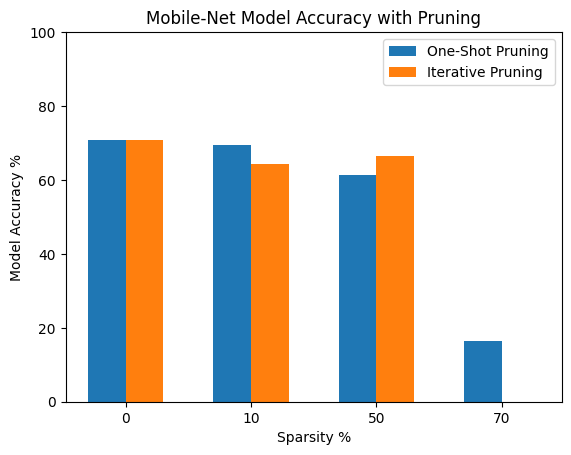

In [ ]:
target_sparsity = ["0", "10", "50", "70"]

# used for plotting multiple bars on one graph
X_axis = np.arange(len(target_sparsity))

Oneshot_prune = plt.bar(X_axis - 0.15, mobilenet_model_acc_prune, 0.3)
Iter_prune = plt.bar(X_axis + 0.15, mobilenet_model_acc_iter_prune, 0.3)

# plot specifications
plt.xticks(X_axis, target_sparsity)
plt.xlabel('Sparsity %')
plt.ylabel('Model Accuracy %')
plt.legend((Oneshot_prune,Iter_prune),('One-Shot Pruning','Iterative Pruning'))
plt.title('Mobile-Net Model Accuracy with Pruning')
plt.ylim((min(mobilenet_model_acc_iter_prune), 100));
plt.show()

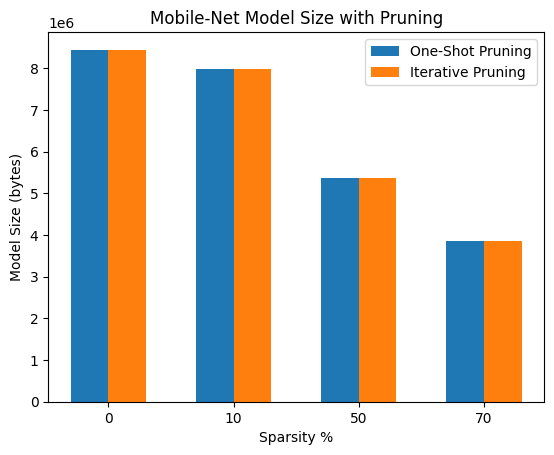

In [ ]:
target_sparsity = ["0", "10", "50", "70"]

# used for plotting multiple bars on one graph
X_axis = np.arange(len(target_sparsity))

Oneshot_prune = plt.bar(X_axis - 0.15, mobilenet_model_size_prune, 0.3)
Iter_prune = plt.bar(X_axis + 0.15, mobilenet_model_size_iter_prune, 0.3)

# plot specifications
plt.xticks(X_axis, target_sparsity)
plt.xlabel('Sparsity %')
plt.ylabel('Model Size (bytes)')
plt.legend((Oneshot_prune,Iter_prune),('One-Shot Pruning','Iterative Pruning'))
plt.title('Mobile-Net Model Size with Pruning');

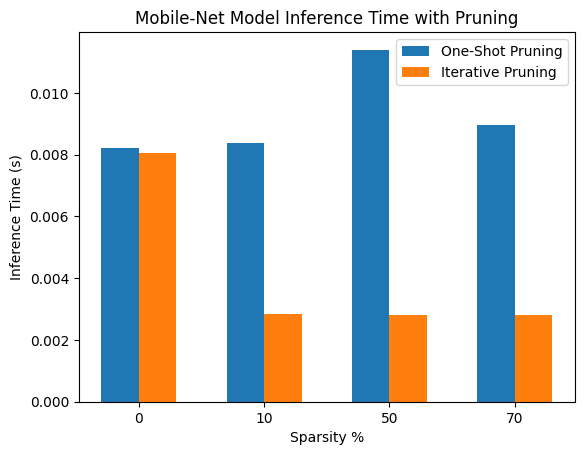

In [ ]:
target_sparsity = ["0", "10", "50", "70"]

# used for plotting multiple bars on one graph
X_axis = np.arange(len(target_sparsity))

Oneshot_prune = plt.bar(X_axis - 0.15, mobilenet_model_time_prune, 0.3)
Iter_prune = plt.bar(X_axis + 0.15, mobilenet_model_time_iter_prune, 0.3)

# plot specifications
plt.xticks(X_axis, target_sparsity)
plt.xlabel('Sparsity %')
plt.ylabel('Inference Time (s)')
plt.legend((Oneshot_prune,Iter_prune),('One-Shot Pruning','Iterative Pruning'))
plt.title('Mobile-Net Model Inference Time with Pruning');

# CNN vs. MobileNet Results

In [ ]:
# **values need to be manually put in for graphs because google colab limitations and notebook restarts (variables keep resetting)**
Final_CNN_model_acc_PQ = [91.90]
Final_CNN_model_acc_PC = [89.09]
Final_CNN_model_acc_PQ8C = [19.72]
Final_CNN_model_acc_PQ16C = [90.14]
Mobilenet_model_acc = mobilenet_model_acc_iter_prune[2]

Final_CNN_model_size_PQ = [955818.00]
Final_CNN_model_size_PC = [528417.00]
Final_CNN_model_size_PQ8C = [399655.00]
Final_CNN_model_size_PQ16C = [465072.00]
Mobilenet_model_size = mobilenet_model_size_iter_prune[2]

Final_CNN_model_time_PQ = [7.348E-5]
Final_CNN_model_time_PC = [0.0378]
Final_CNN_model_time_PQ8C = [7.86E-5]
Final_CNN_model_time_PQ16C = [7.23E-5]
Mobilenet_model_time = mobilenet_model_time_iter_prune[2]

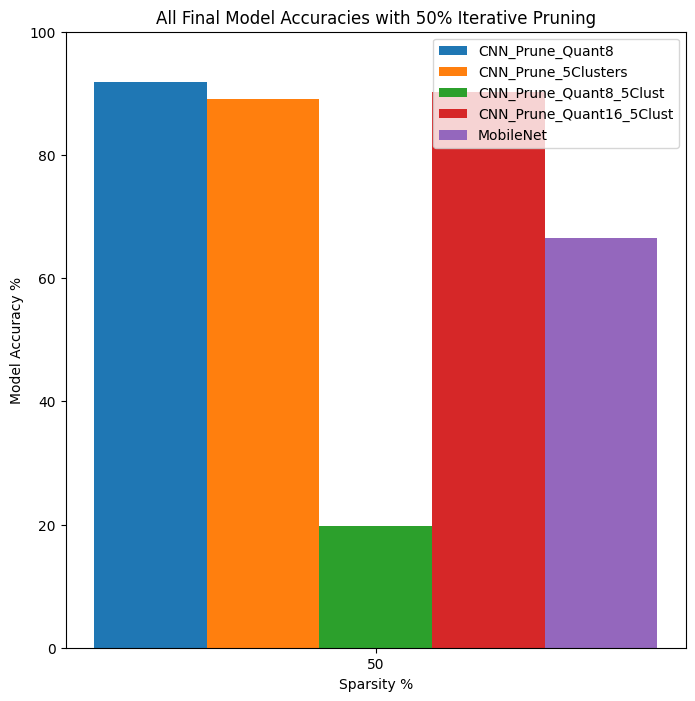

<Figure size 500x500 with 0 Axes>

In [ ]:
target_sparsity = ["50"]

# used for plotting multiple bars on one graph
X_axis = np.arange(len(target_sparsity))

CNN_PQ = plt.bar(X_axis - 0.1, Final_CNN_model_acc_PQ, 0.05, align='center')
CNN_PC = plt.bar(X_axis - 0.05, Final_CNN_model_acc_PC, 0.05, align='center')
CNN_PQ8C = plt.bar(X_axis, Final_CNN_model_acc_PQ8C, 0.05, align='center')
CNN_PQ16C = plt.bar(X_axis + 0.05, Final_CNN_model_acc_PQ16C, 0.05, align='center')
Mobilenet_acc = plt.bar(X_axis + 0.1, Mobilenet_model_acc, 0.05, align='center')

# plot specifications
plt.xticks(X_axis, target_sparsity)
plt.xlabel('Sparsity %')
plt.ylabel('Model Accuracy %')
plt.legend((CNN_PQ, CNN_PC, CNN_PQ8C, CNN_PQ16C, Mobilenet_acc),('CNN_Prune_Quant8','CNN_Prune_5Clusters', 'CNN_Prune_Quant8_5Clust', 'CNN_Prune_Quant16_5Clust','MobileNet'))
plt.title('All Final Model Accuracies with 50% Iterative Pruning')
plt.ylim((min(mobilenet_model_acc_iter_prune), 100));
plt.figure(figsize=(10, 10), dpi=50)
plt.show()

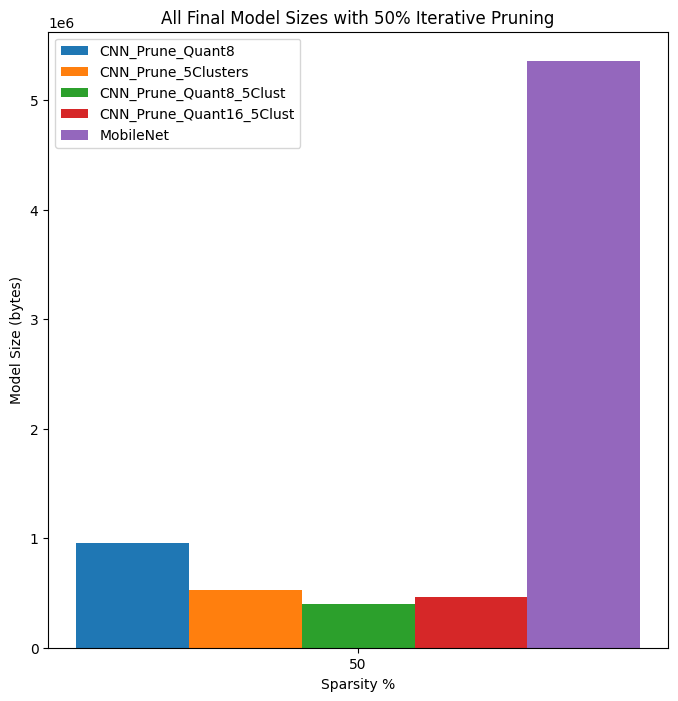

<Figure size 500x500 with 0 Axes>

In [ ]:
target_sparsity = ["50"]

# used for plotting multiple bars on one graph
X_axis = np.arange(len(target_sparsity))

CNN_PQ = plt.bar(X_axis - 0.1, Final_CNN_model_size_PQ, 0.05, align='center')
CNN_PC = plt.bar(X_axis - 0.05, Final_CNN_model_size_PC, 0.05, align='center')
CNN_PQ8C = plt.bar(X_axis, Final_CNN_model_size_PQ8C, 0.05, align='center')
CNN_PQ16C = plt.bar(X_axis + 0.05, Final_CNN_model_size_PQ16C, 0.05, align='center')
Mobilenet_acc = plt.bar(X_axis + 0.1, Mobilenet_model_size, 0.05, align='center')

# plot specifications
plt.xticks(X_axis, target_sparsity)
plt.xlabel('Sparsity %')
plt.ylabel('Model Size (bytes)')
plt.legend((CNN_PQ, CNN_PC, CNN_PQ8C, CNN_PQ16C, Mobilenet_acc),('CNN_Prune_Quant8','CNN_Prune_5Clusters', 'CNN_Prune_Quant8_5Clust', 'CNN_Prune_Quant16_5Clust','MobileNet'))
plt.title('All Final Model Sizes with 50% Iterative Pruning')
plt.figure(figsize=(10, 10), dpi=50)
plt.show()

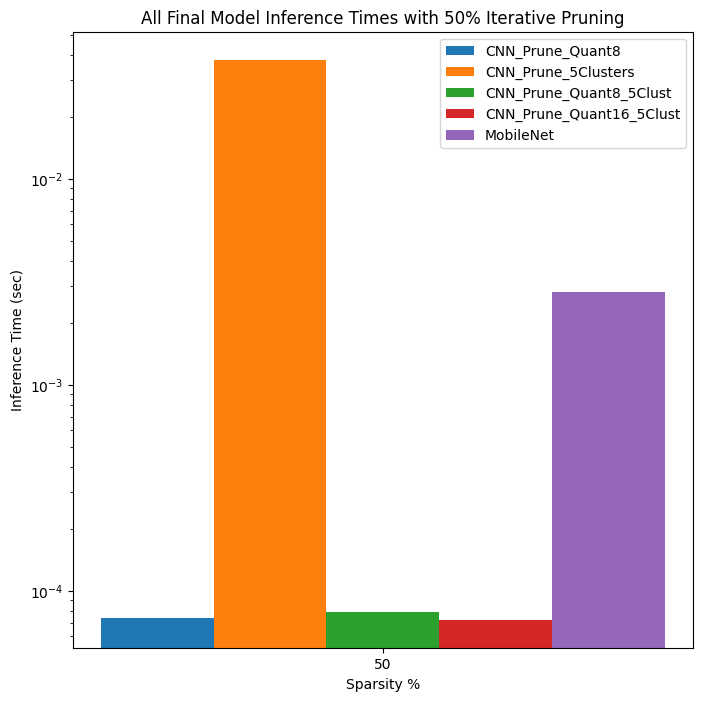

In [ ]:
target_sparsity = ["50"]

# used for plotting multiple bars on one graph
X_axis = np.arange(len(target_sparsity))

CNN_PQ = plt.bar(X_axis - 0.1, Final_CNN_model_time_PQ, 0.05, align='center')
CNN_PC = plt.bar(X_axis - 0.05, Final_CNN_model_time_PC, 0.05, align='center')
CNN_PQ8C = plt.bar(X_axis, Final_CNN_model_time_PQ8C, 0.05, align='center')
CNN_PQ16C = plt.bar(X_axis + 0.05, Final_CNN_model_time_PQ16C, 0.05, align='center')
Mobilenet_acc = plt.bar(X_axis + 0.1, Mobilenet_model_time, 0.05, align='center')

# plot specifications
plt.xticks(X_axis, target_sparsity)
plt.xlabel('Sparsity %')
plt.ylabel('Inference Time (sec)')
plt.legend((CNN_PQ, CNN_PC, CNN_PQ8C, CNN_PQ16C, Mobilenet_acc),('CNN_Prune_Quant8','CNN_Prune_5Clusters', 'CNN_Prune_Quant8_5Clust', 'CNN_Prune_Quant16_5Clust','MobileNet'))
plt.title('All Final Model Inference Times with 50% Iterative Pruning')
plt.yscale('log')
plt.show()